# Take-Home Challenge: Ultimate Technologies Inc.

## Part 1: Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
# Import the required modules
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense


%matplotlib inline

Using TensorFlow backend.


In [2]:
# Read the login data into a dataframe and inspect the first 5 elements
logins = pd.read_json('logins.json')
logins.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

In [3]:
# Show some interesting properties of the data
print(logins.login_time.max(), ' ', logins.login_time.min())
print('\n',logins.info())
print('\n', logins.describe())

1970-04-13 18:57:38   1970-01-01 20:12:16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB

 None

                  login_time
count                 93142
unique                92265
top     1970-02-12 11:16:53
freq                      3
first   1970-01-01 20:12:16
last    1970-04-13 18:57:38


In [4]:
# Shift the datetime info to the index for datetime aggregation operations
logins.index = logins.login_time

# Create an array of single counts for each login time and attach to the dataframe
ones = [1 for i in range(len(logins))]
logins['count'] = ones

# Remove the original column of data
logins.drop('login_time', inplace=True, axis=1)
logins.head()

count
login_time                
1970-01-01 20:13:18      1
1970-01-01 20:16:10      1
1970-01-01 20:16:37      1
1970-01-01 20:16:36      1
1970-01-01 20:26:21      1

In [5]:
# Resample the data into 15 minunte intervals, summing the number of logins in each interval
logins_resample = logins.resample('15T').sum()
logins_resample.head()

count
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1

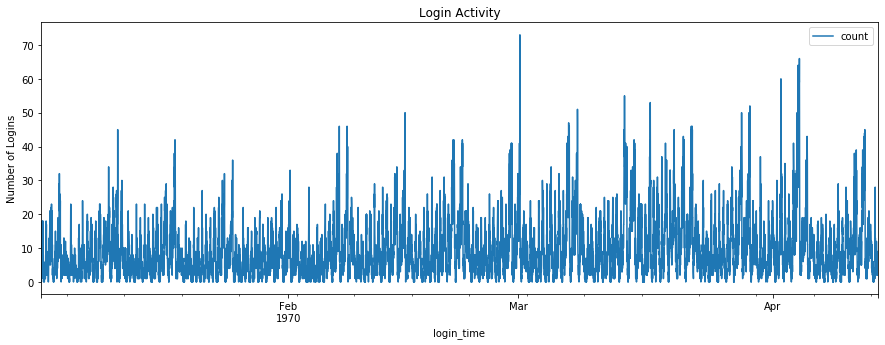

In [6]:
# Create a plot to visualize the number of calls in each 15 minute interval over the entire period
_=logins_resample.plot(figsize=(15,5))
_=plt.ylabel('Number of Logins')
_=plt.title('Login Activity')

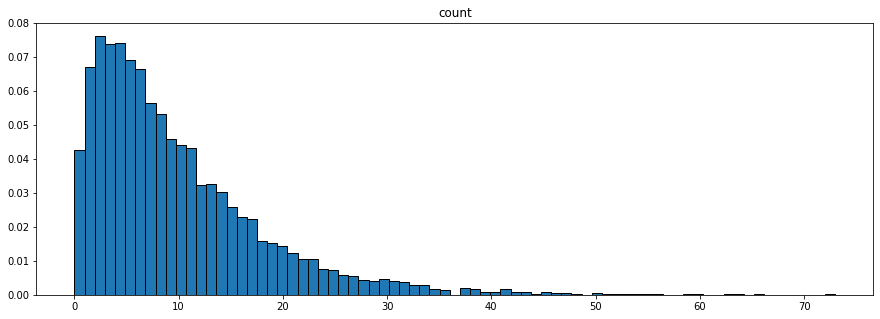

In [7]:
# Create a histogram to see the distribution of login counts
_=logins_resample.hist(figsize=(15,5), bins=75, grid=False, edgecolor='k', density=True)

The above plots show a definite cyclic pattern in login activity throughout the entire period. Closer examination of shorter time periods will illuminate any patterns that occur in these time frames. The histogram shows that the most likely number of logins in any fifteen minute period will be around 5. There are some extremely high volume bins, but their frequency indicates that this level of activity is extremely rare.

In [8]:
# Create a dataframe to look at the volume in the first 24 hours
tdelta24 = dt.timedelta(hours=24)
logins24h = logins[logins.index < (logins.index[0] + tdelta24)]
logins24h_resample = logins24h.resample('15T').sum()

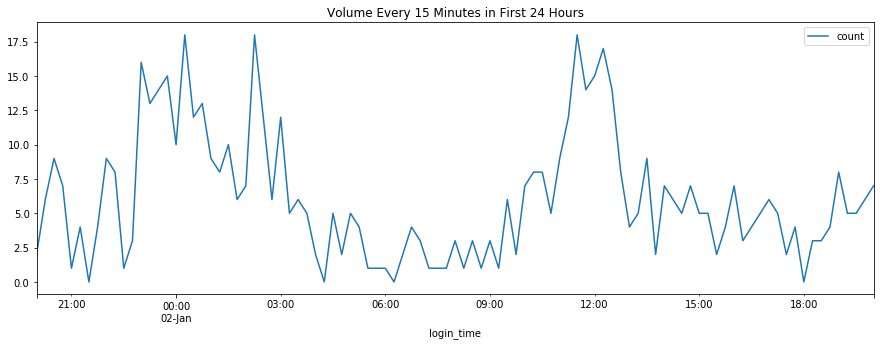

In [9]:
# Visualize the volume every fifteen minutes in the first 24 hours
_=logins24h_resample.plot(figsize=(15,5))
_=plt.title('Volume Every 15 Minutes in First 24 Hours')

The first 24 hour period shows two clear spikes in user activity. Many logins occur aruond lunchtime each day and late at night throughout the early morning, with a clear drop in the early morning hours. 

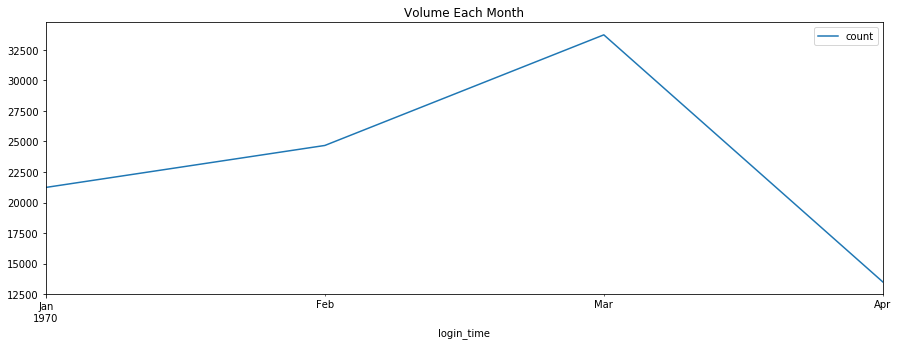

In [10]:
#Visualize the volume every month
temp = logins.resample('1M').sum()
_=temp.plot(figsize=(15,5))
_=plt.title('Volume Each Month')

The monthly usage increases from January and peaks in March. Then there is a precipitous drop off in activity from March to April. The reason for this should be investigated to ensure quality of user experience or guard against loss to competition. The same trend can be seen below in the weekly volume plot: usage continually increases until April where there is a drastic decline in weekly volume.

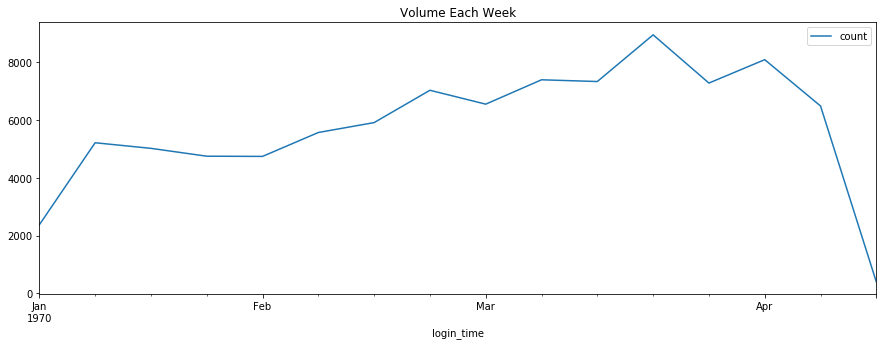

In [11]:
# Visualize the volume every week
temp = logins.resample('1W').sum()
_=temp.plot(figsize=(15,5))
_=plt.title('Volume Each Week')

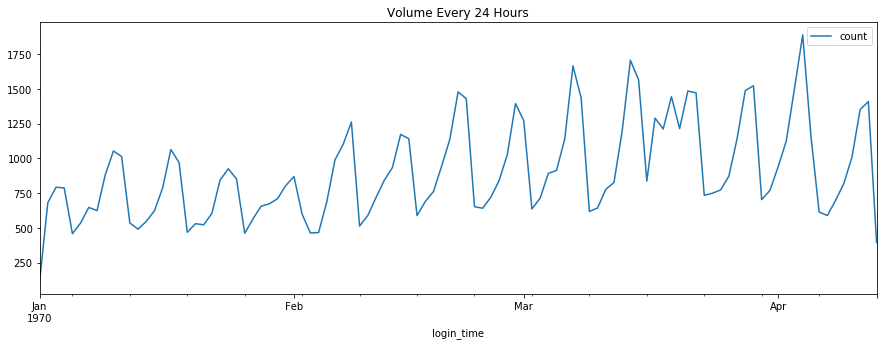

In [12]:
# Visualize the volume every 24 Hours
temp = logins.resample('24H').sum()
_=temp.plot(figsize=(15,5))
_=plt.title('Volume Every 24 Hours')

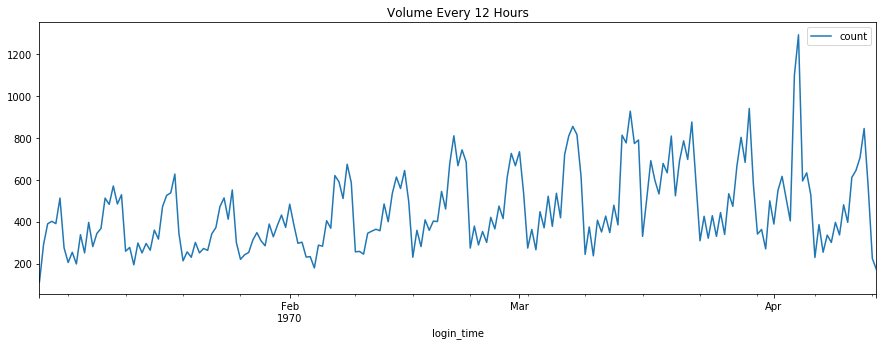

In [13]:
# Visualize the volume every 12 Hours
temp = logins.resample('12H').sum()
_=temp.plot(figsize=(15,5))
_=plt.title('Volume Every 12 Hours')

Observing the login activity over 12 and 24 hour periods reveals a cyclic pattern in demand. Again we can see this increasing over time as the peaks rise higher, then decline in April. 

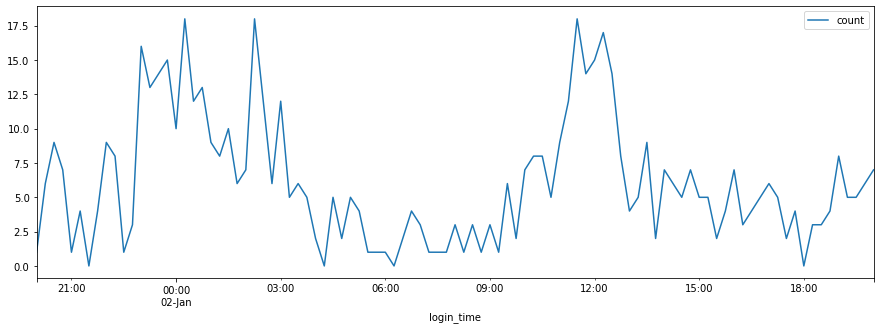

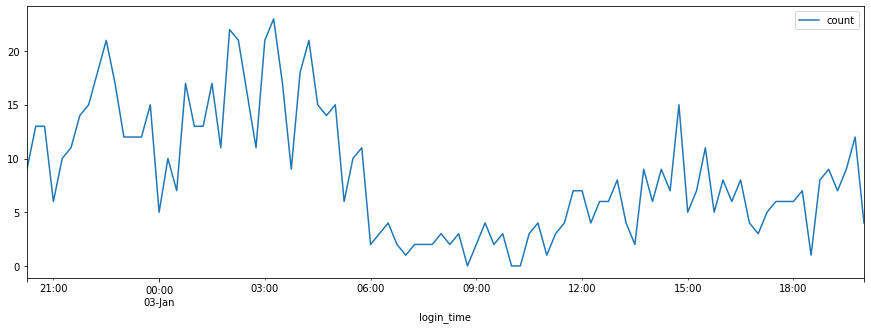

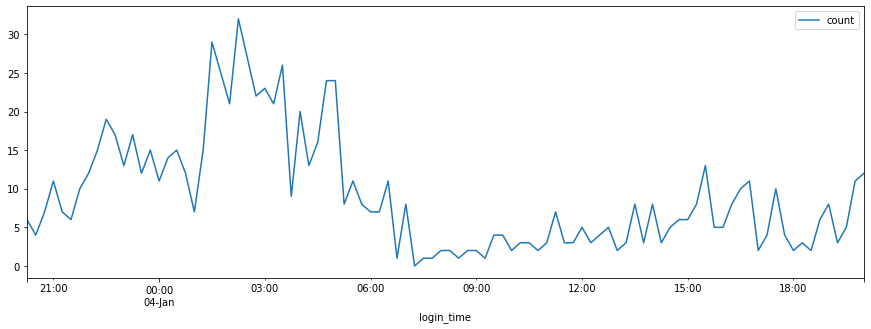

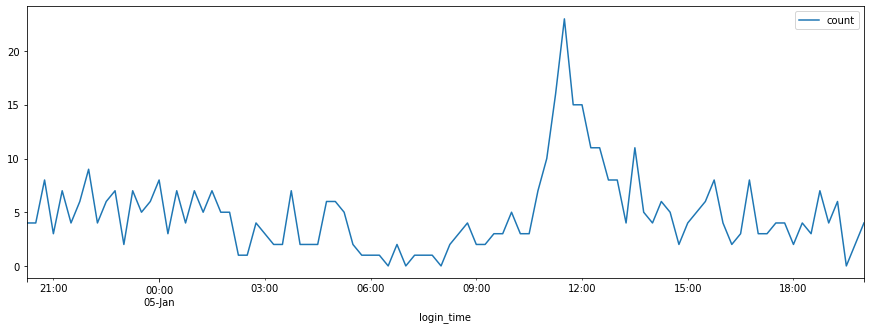

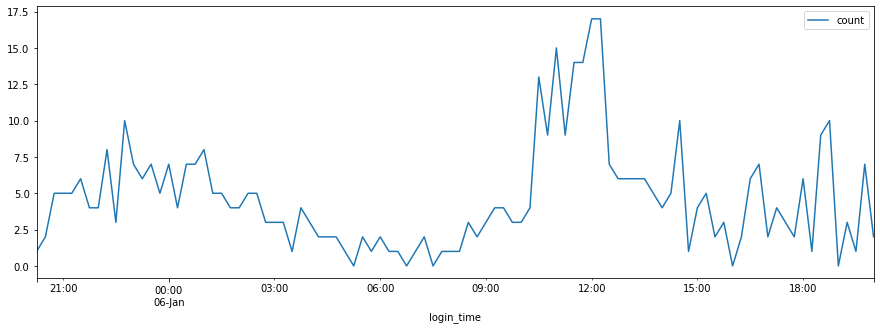

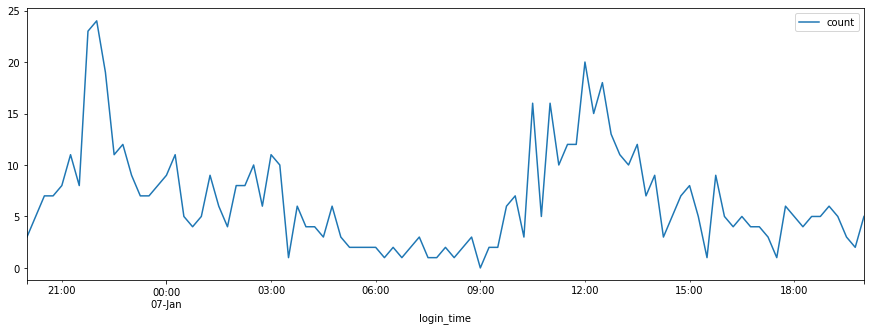

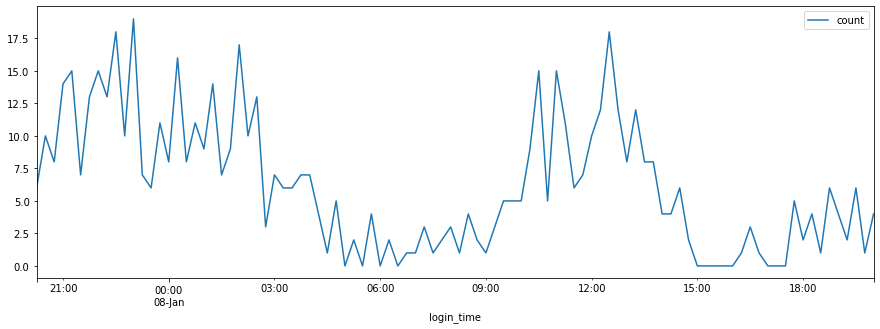

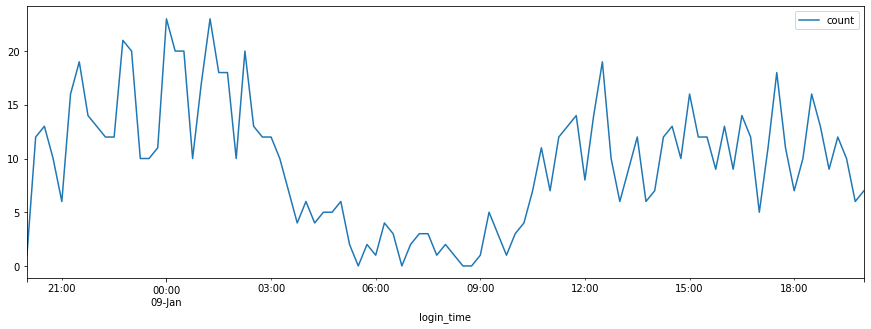

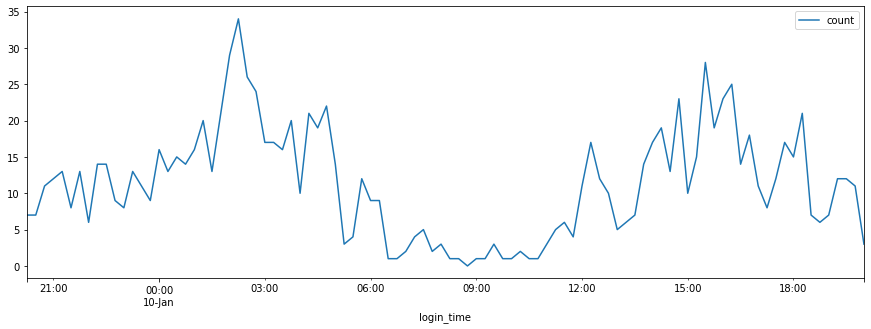

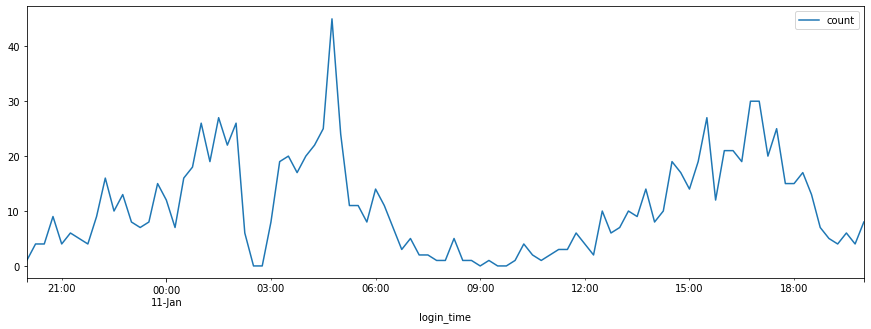

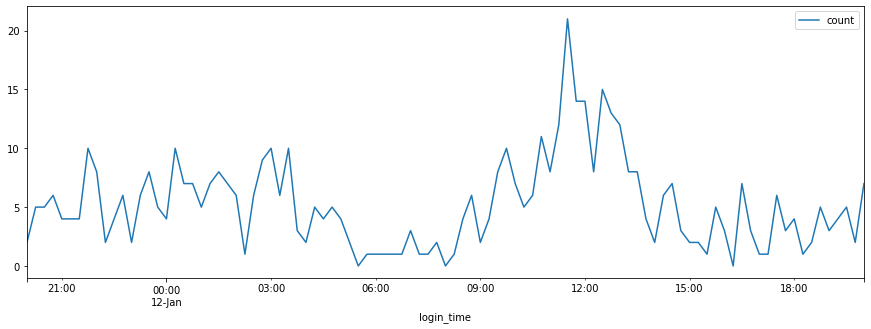

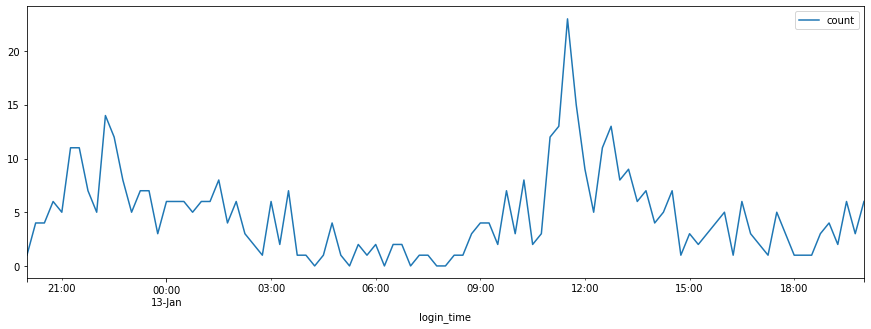

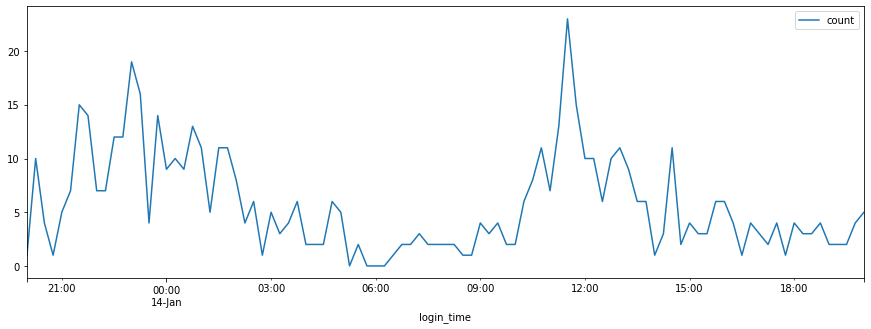

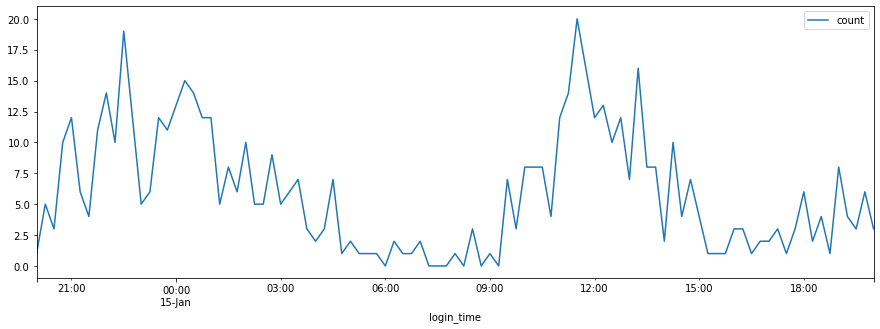

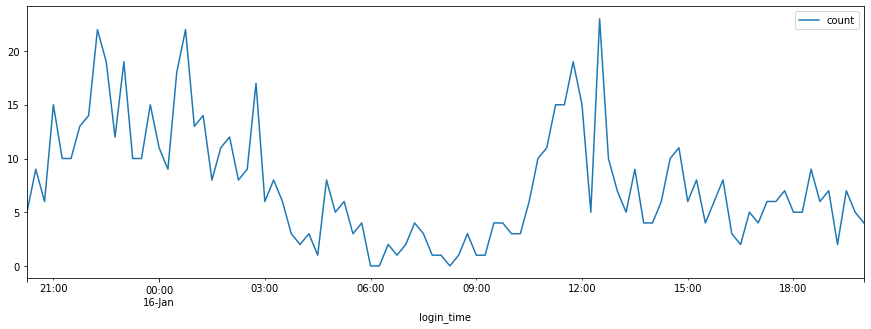

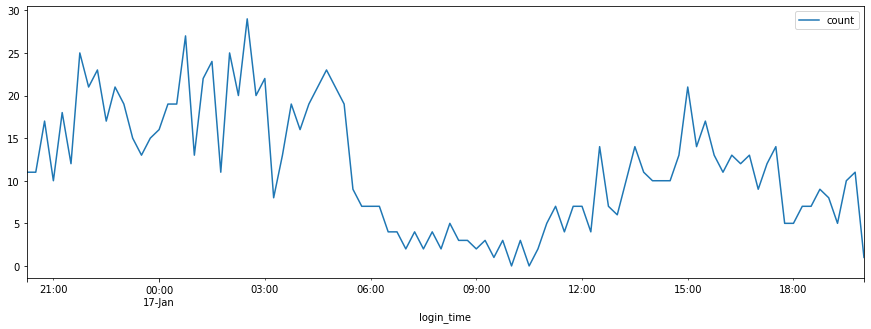

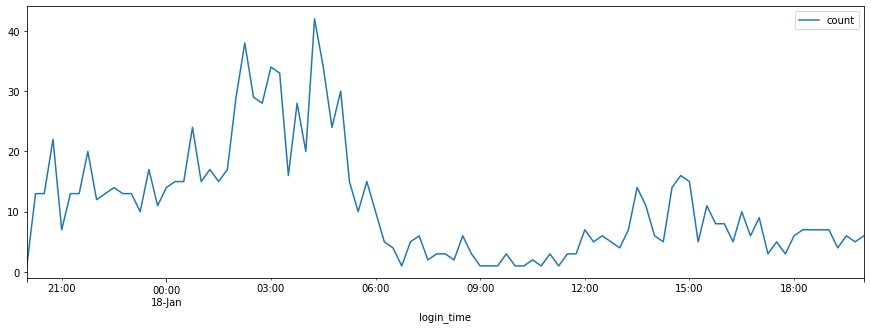

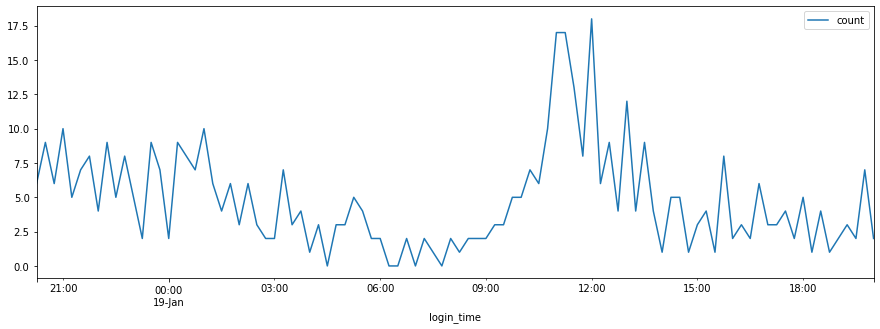

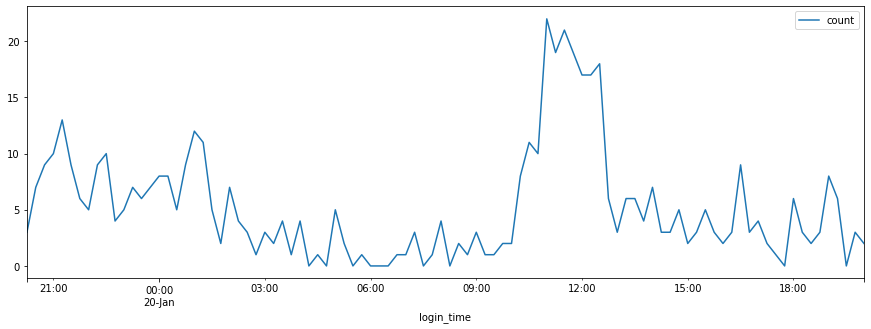

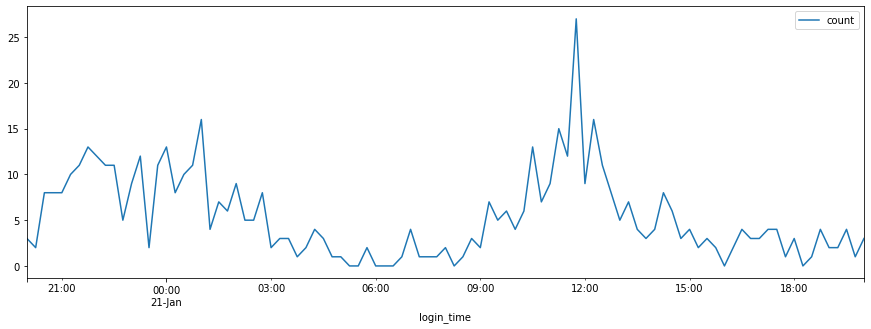

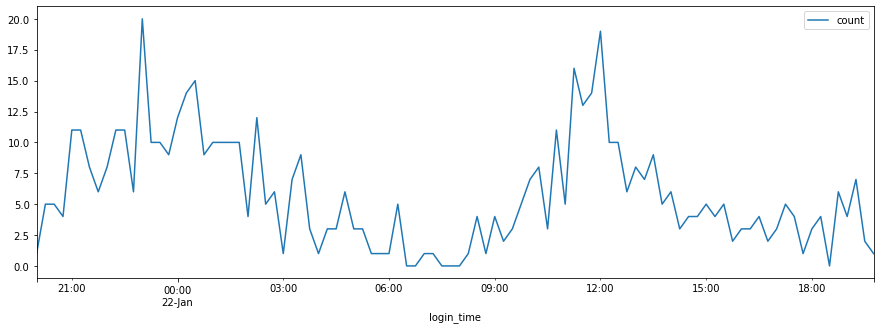

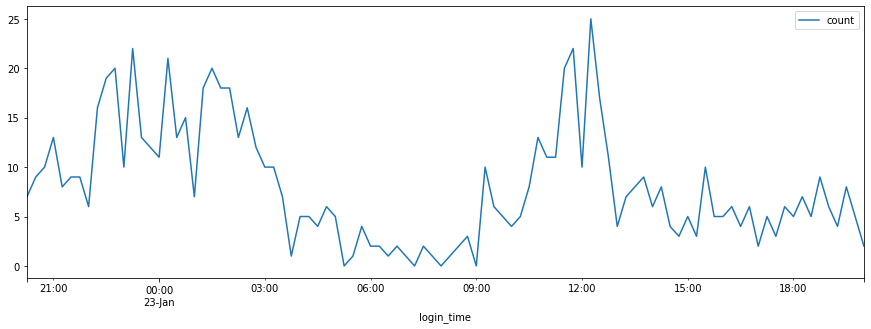

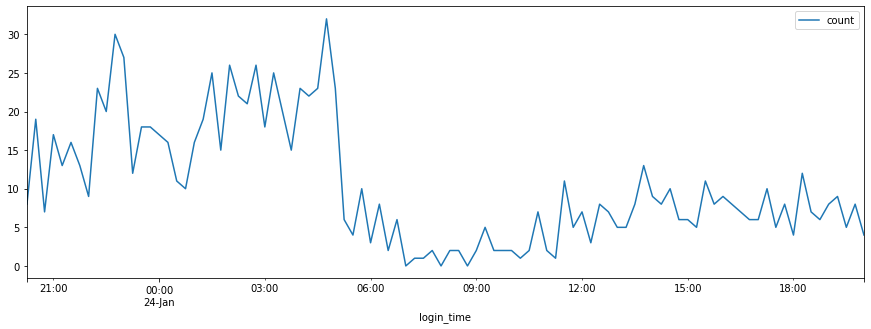

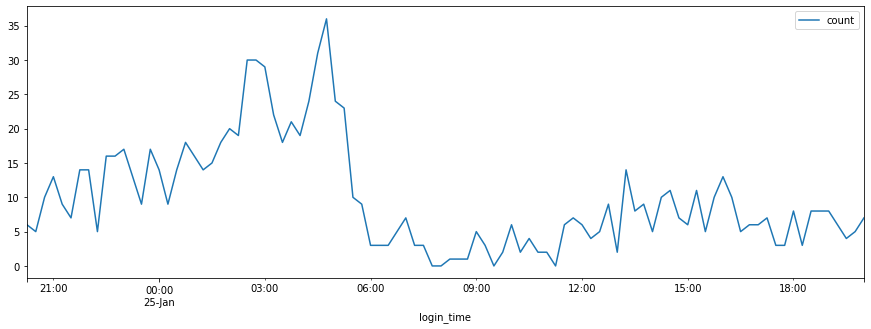

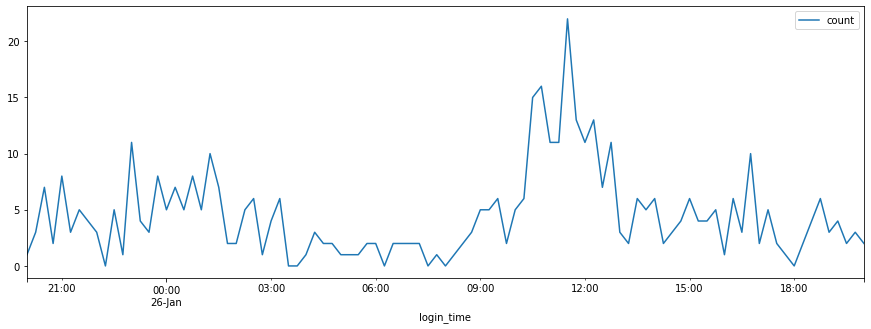

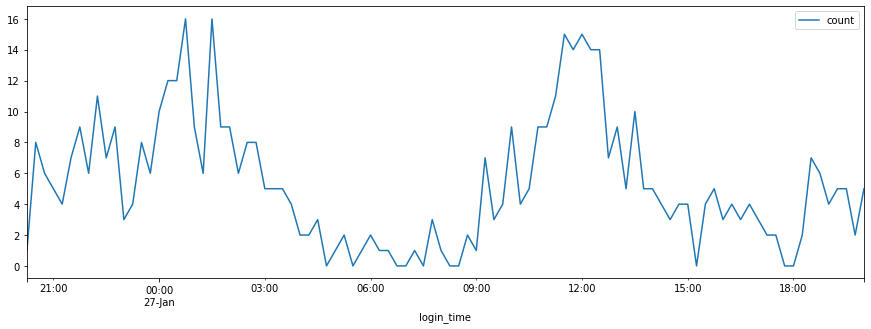

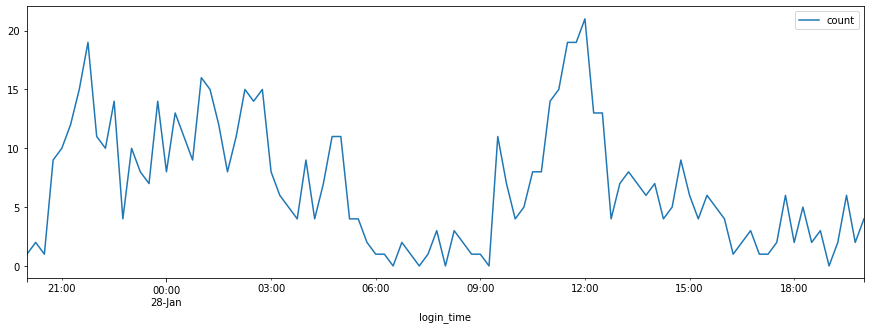

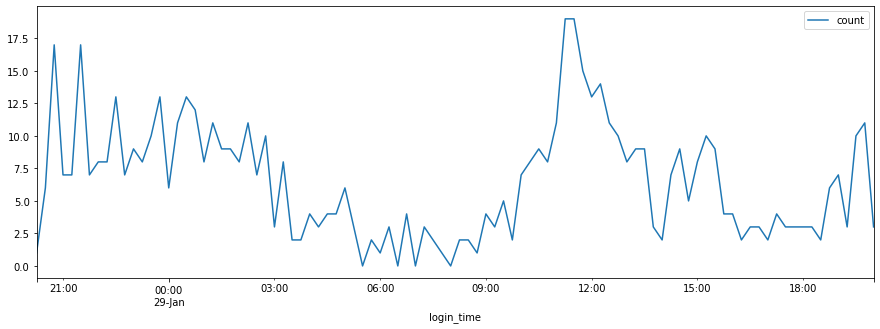

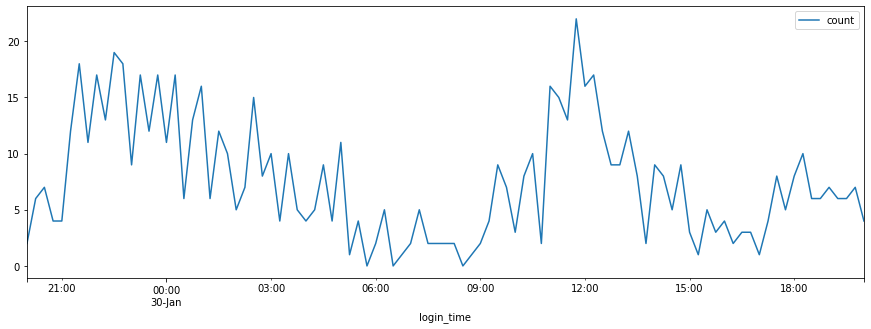

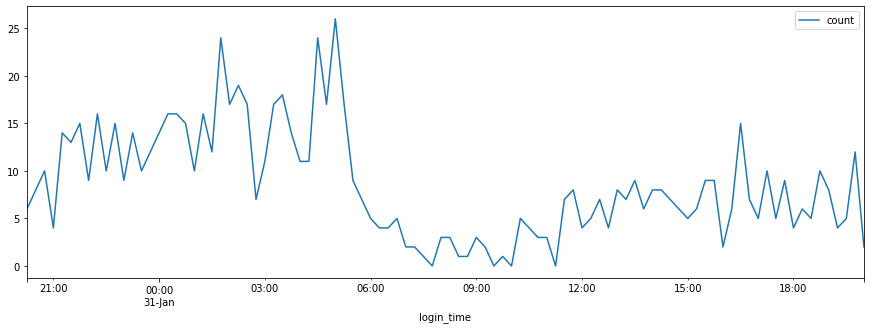

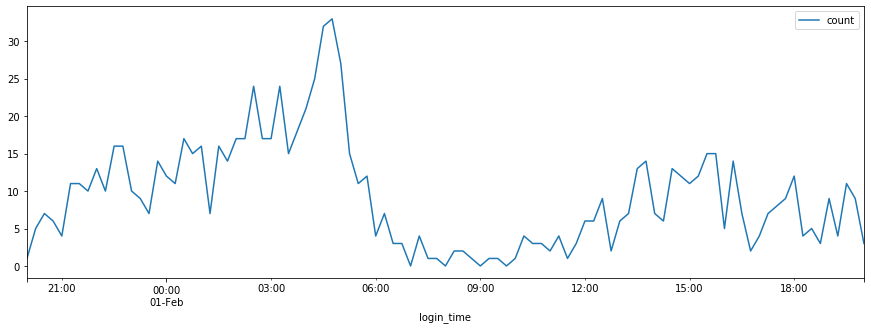

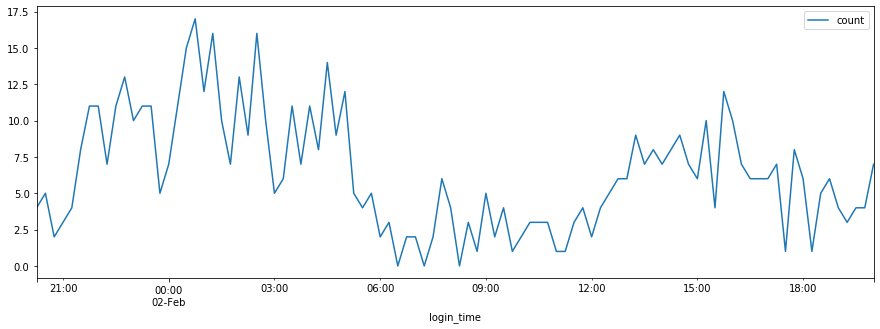

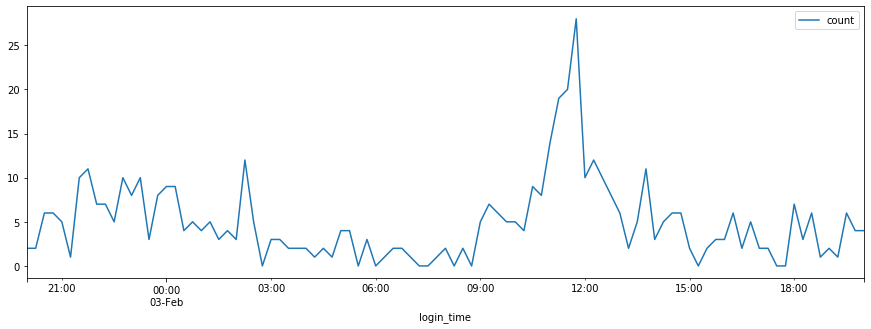

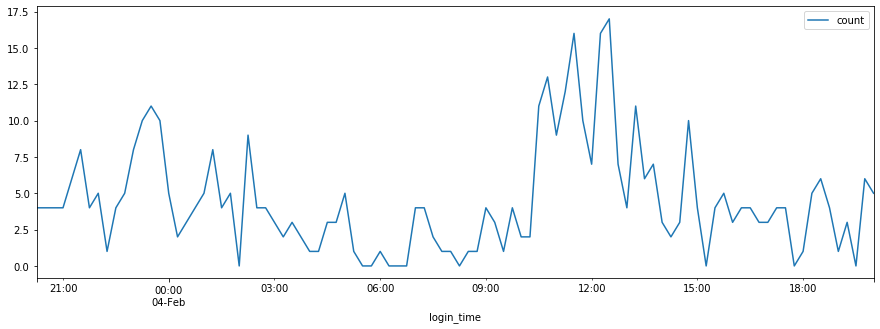

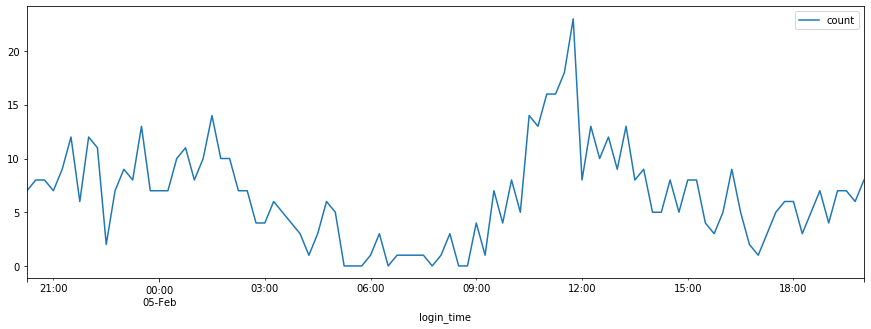

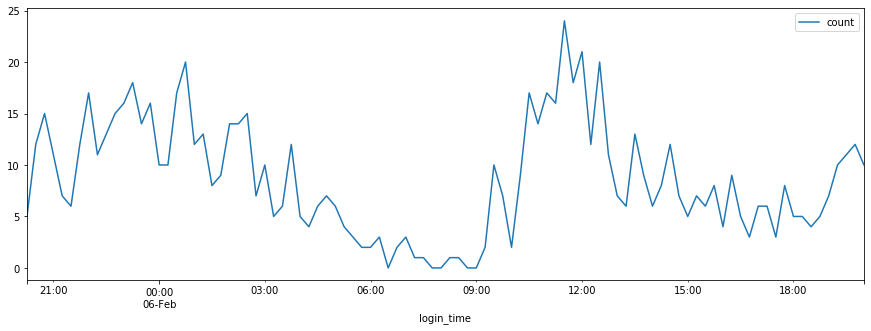

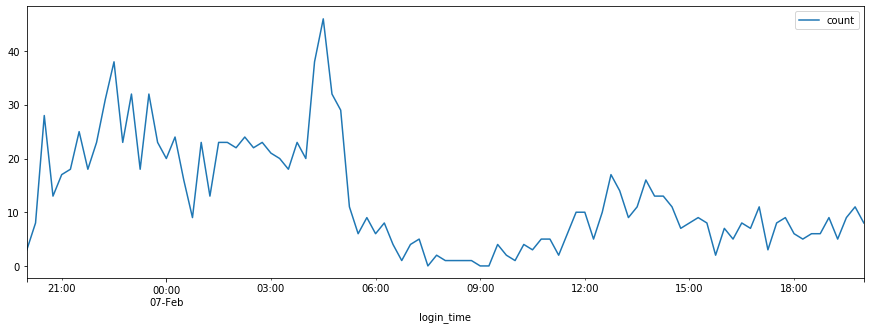

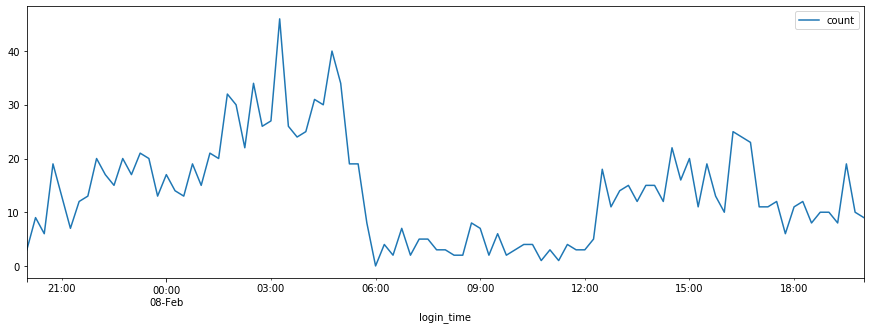

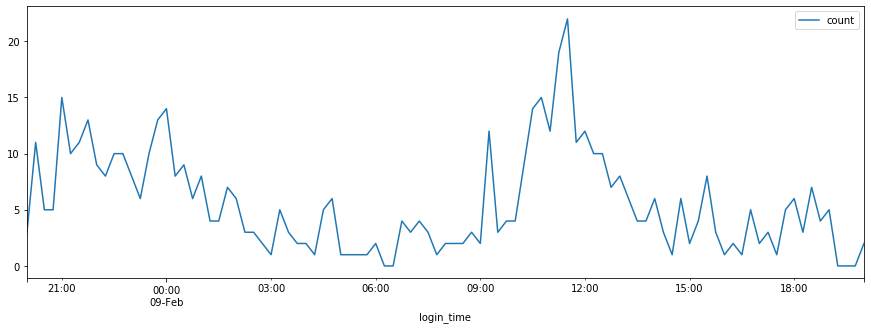

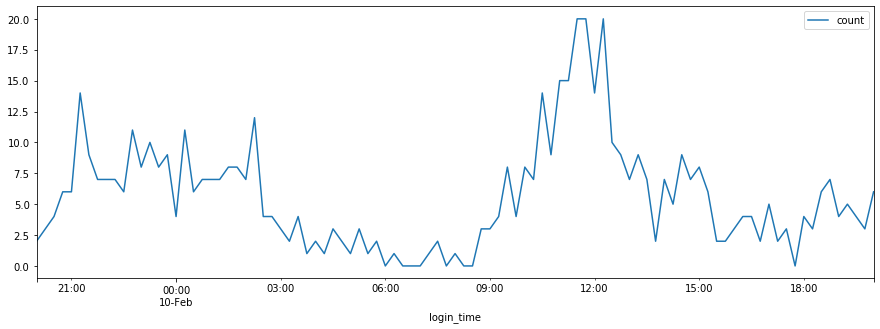

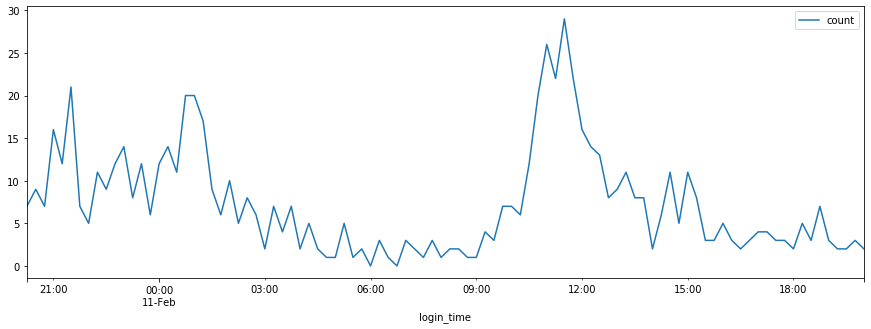

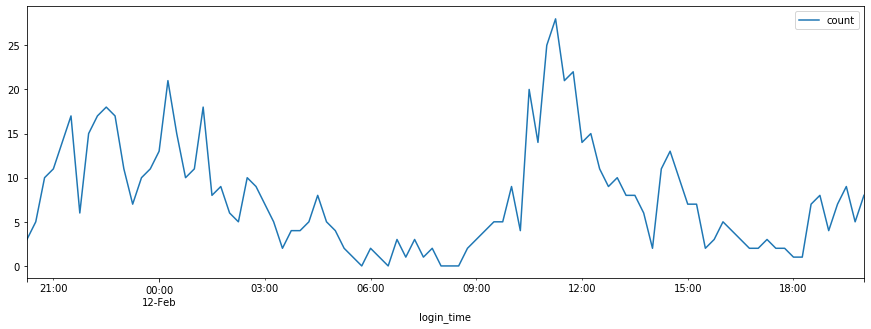

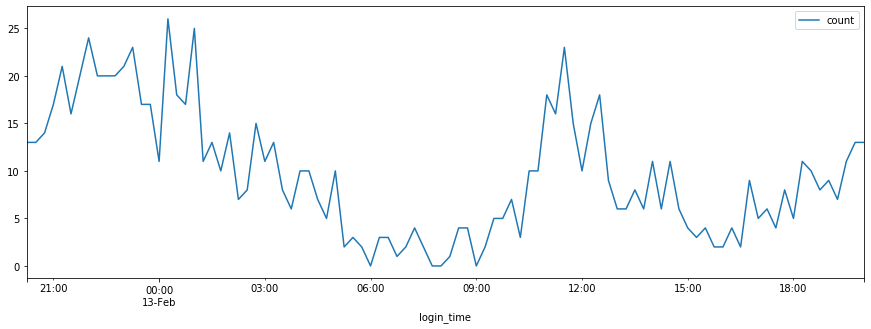

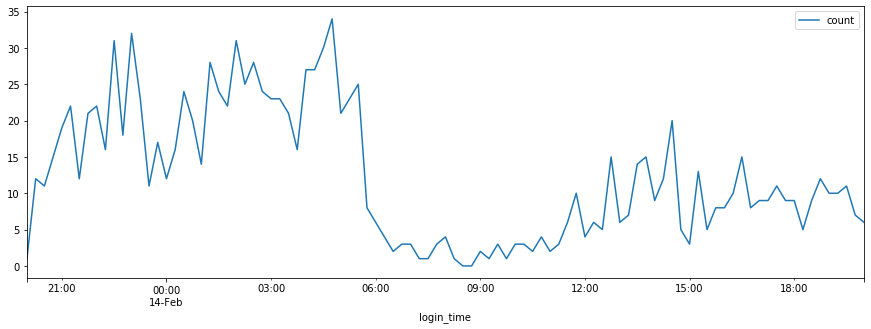

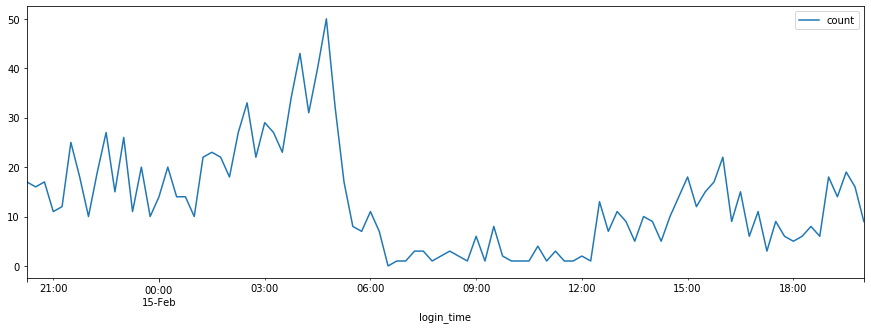

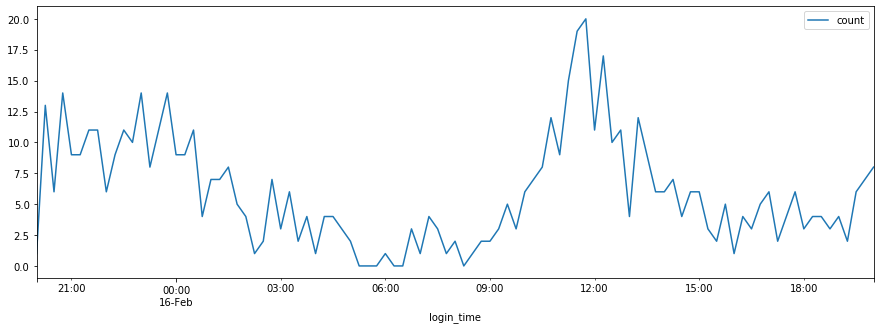

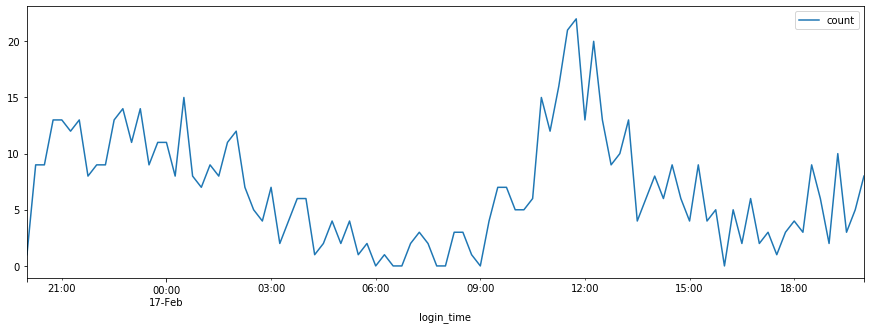

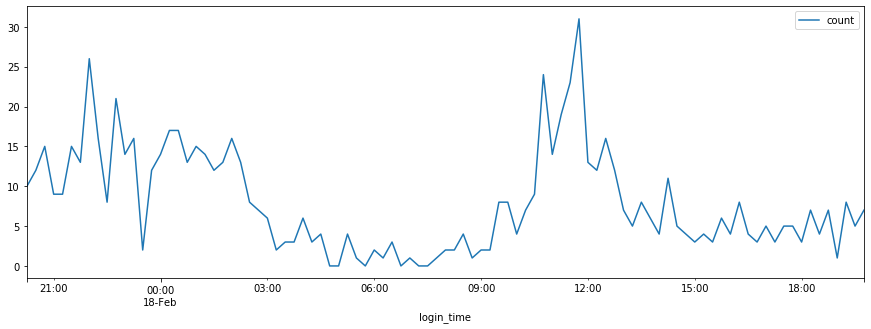

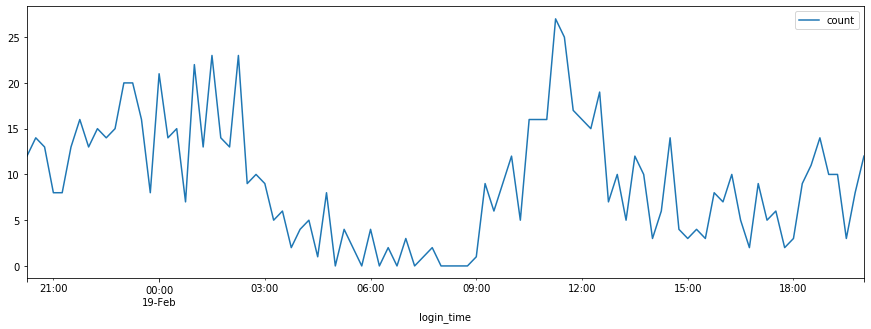

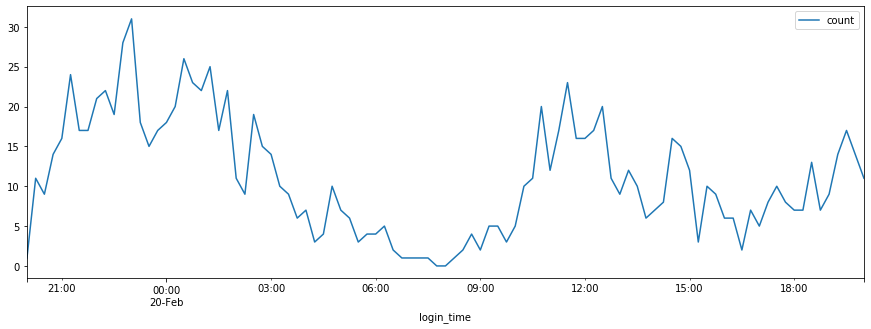

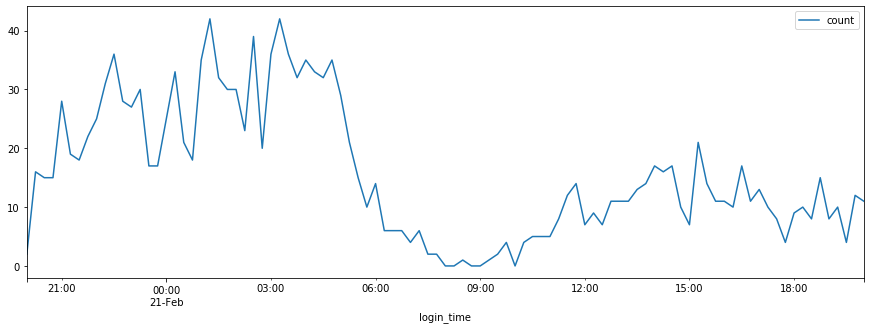

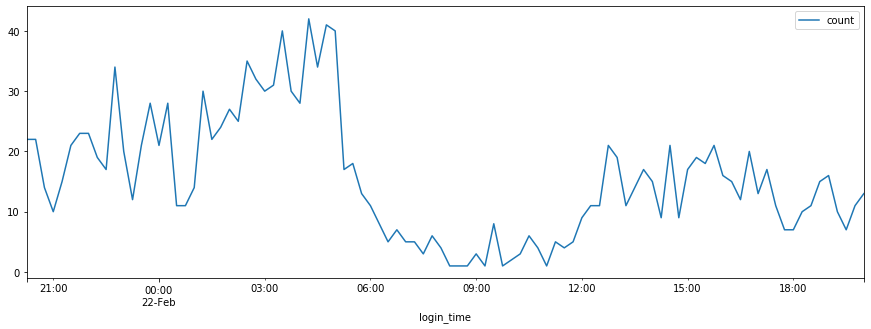

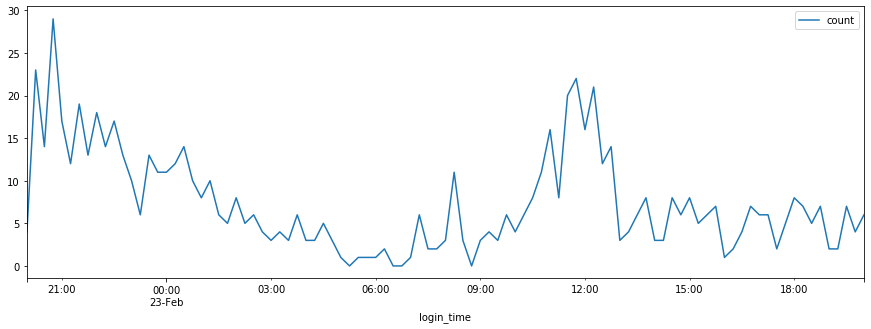

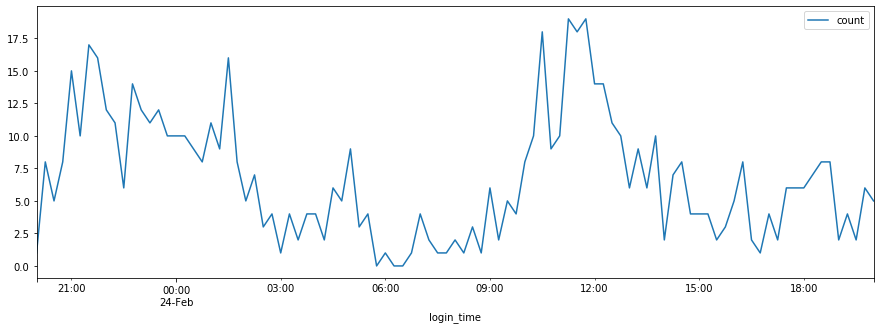

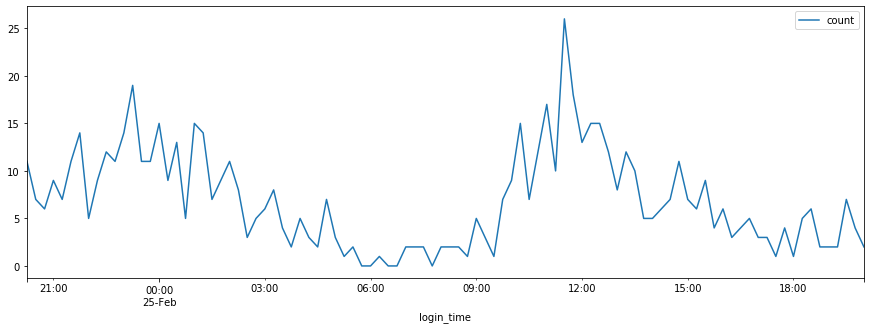

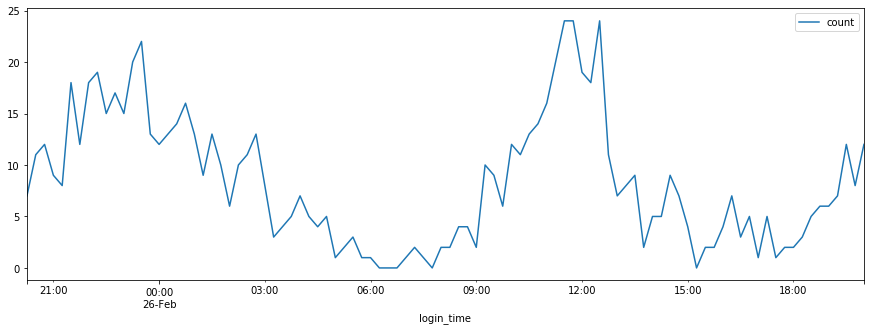

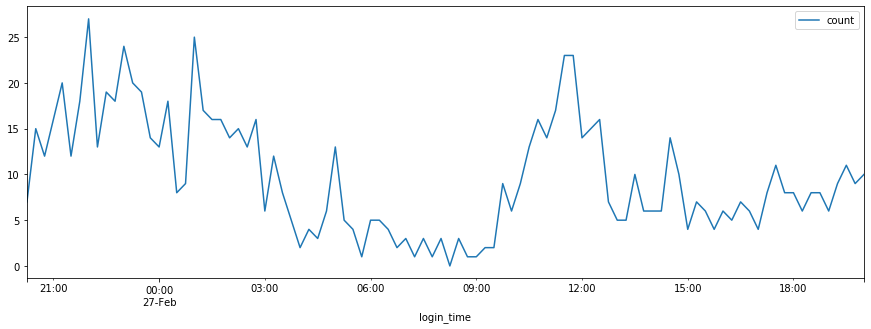

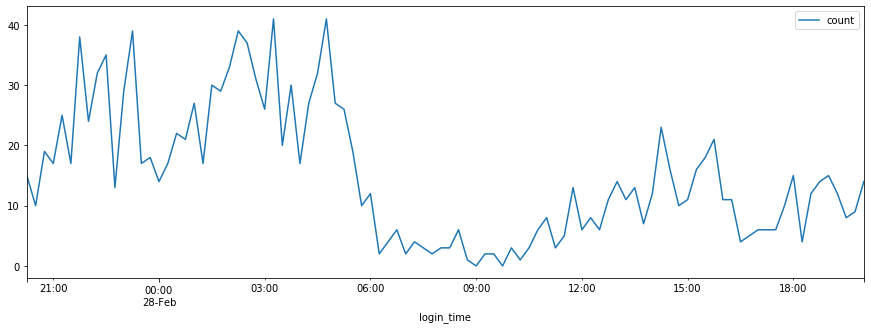

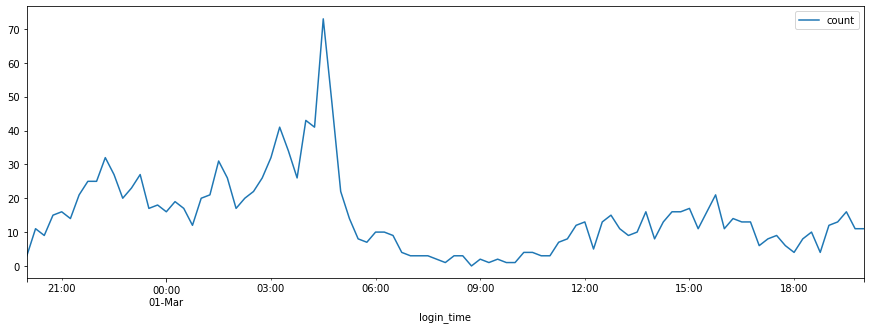

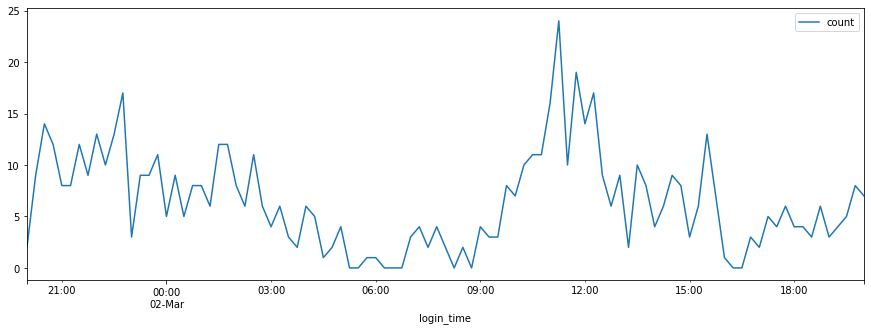

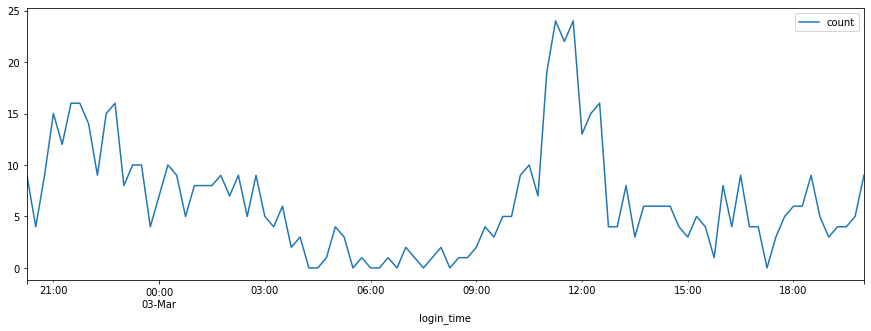

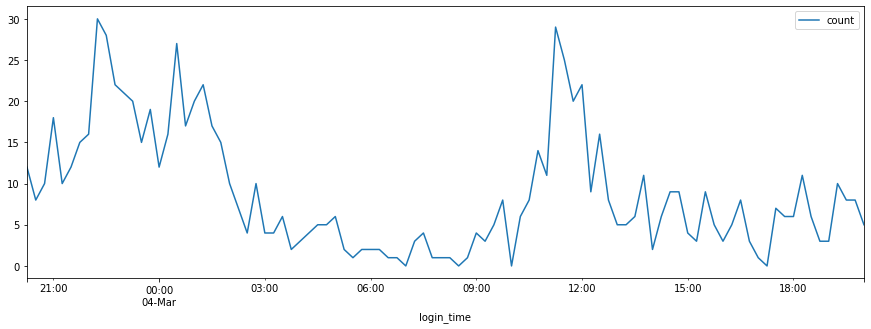

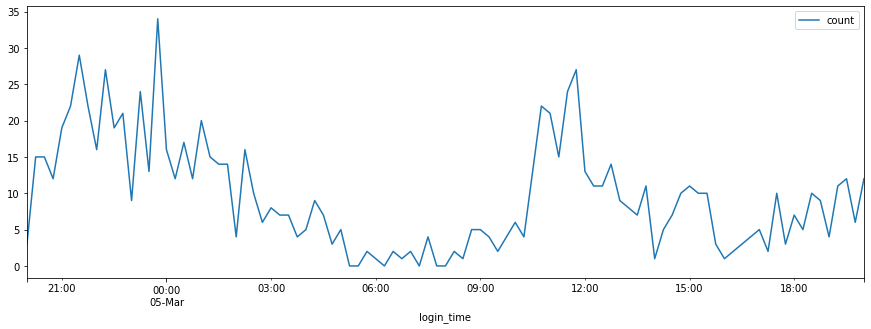

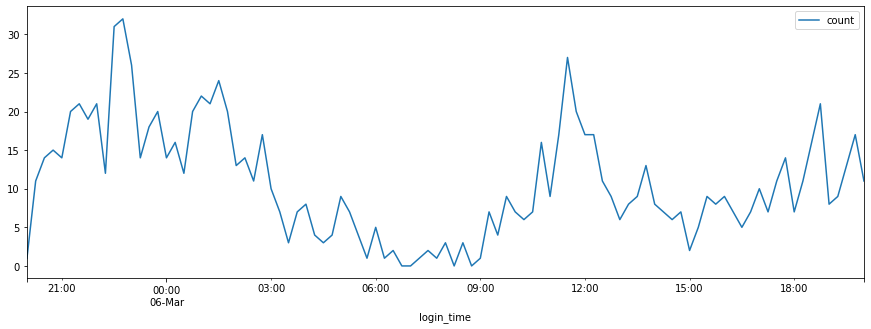

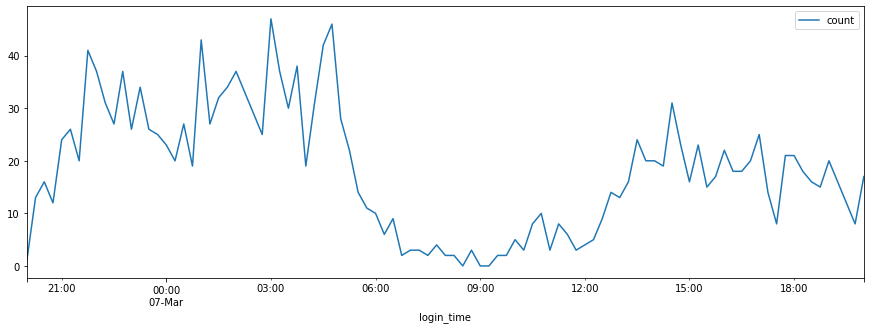

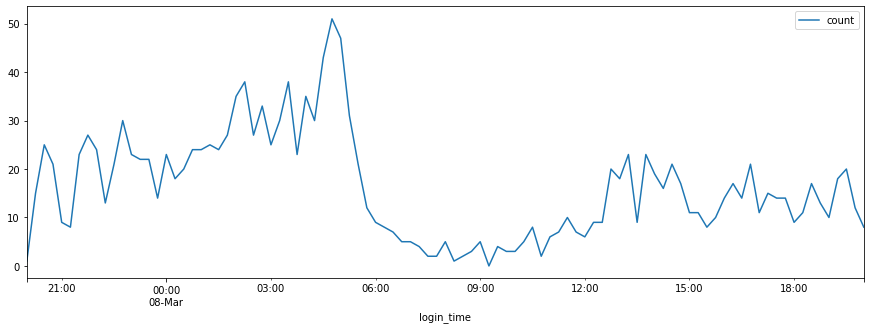

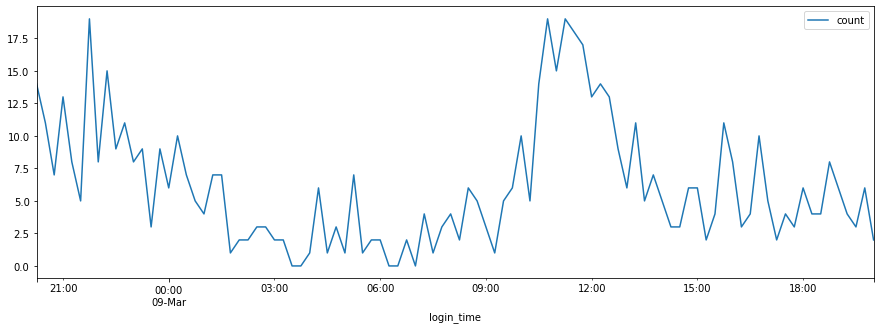

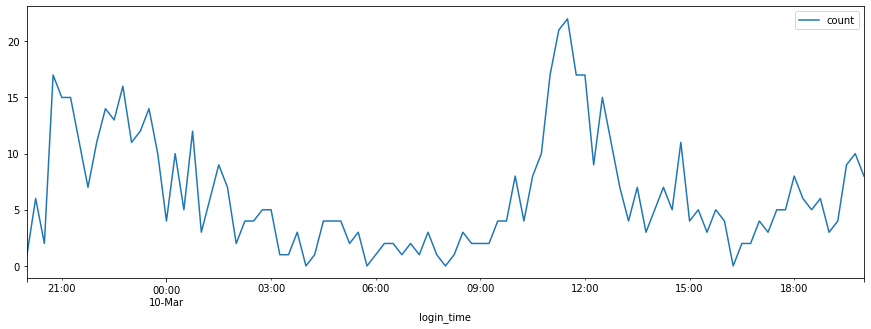

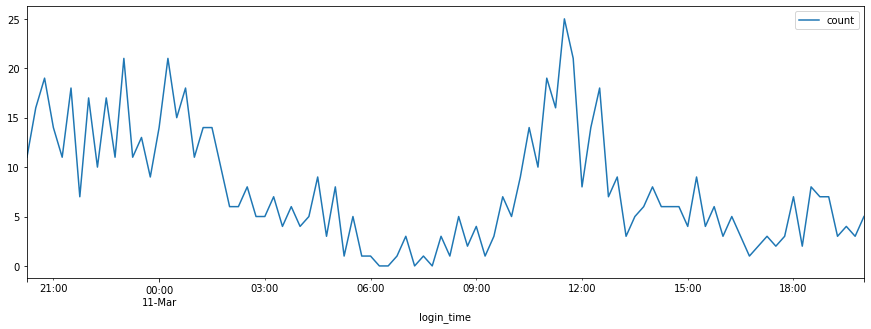

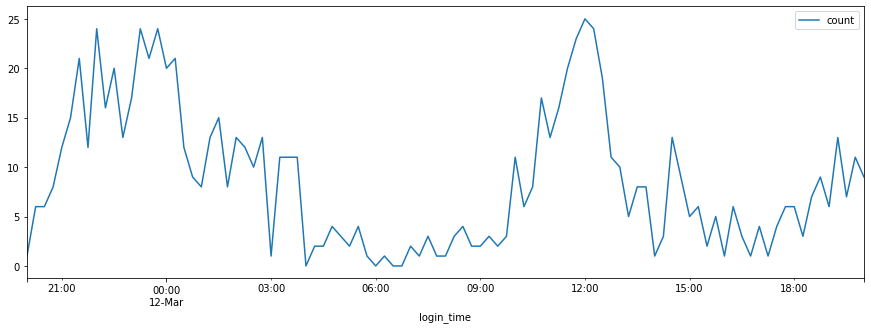

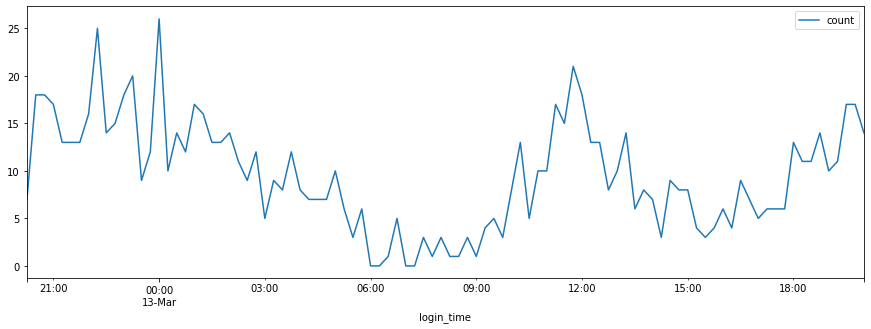

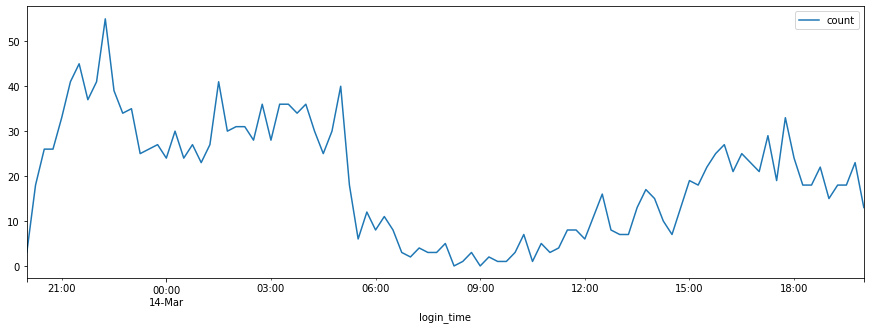

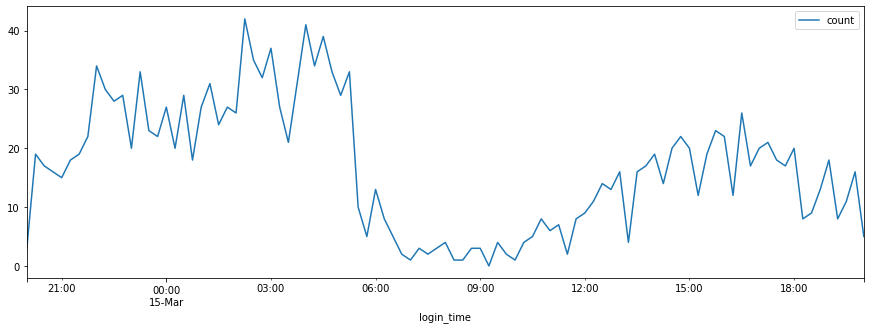

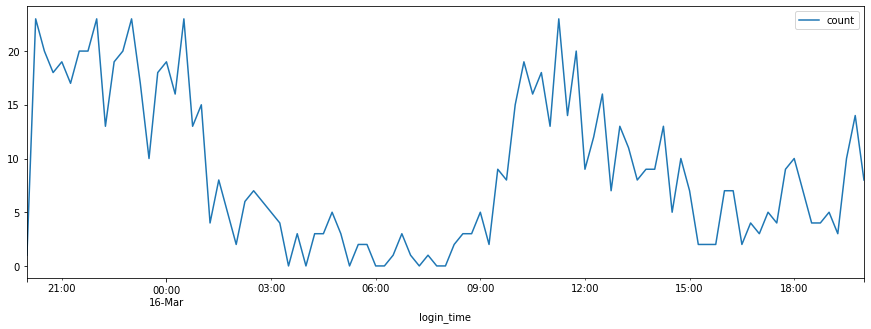

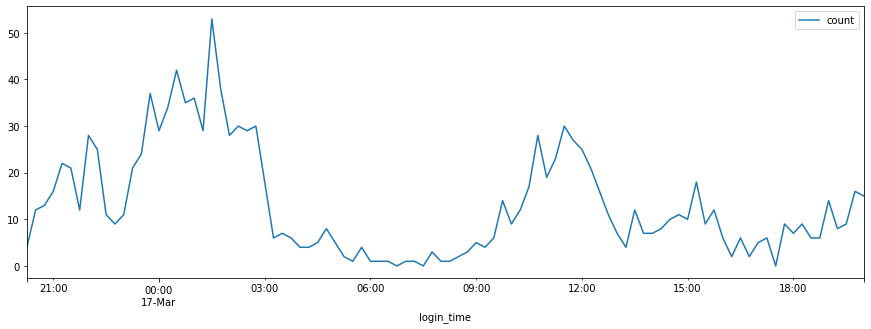

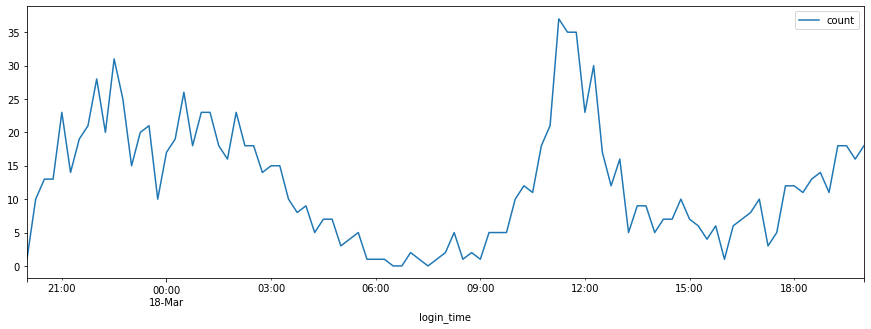

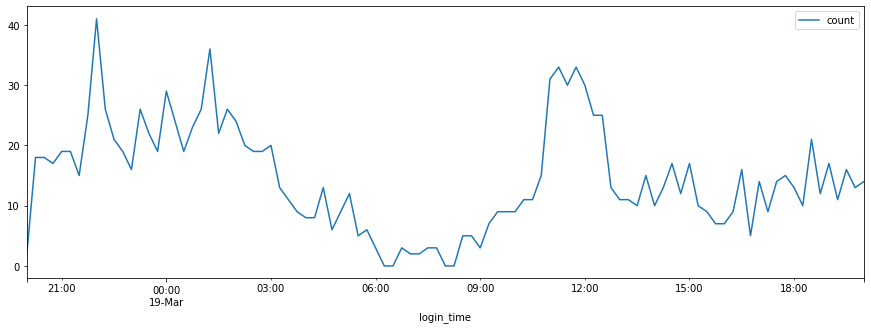

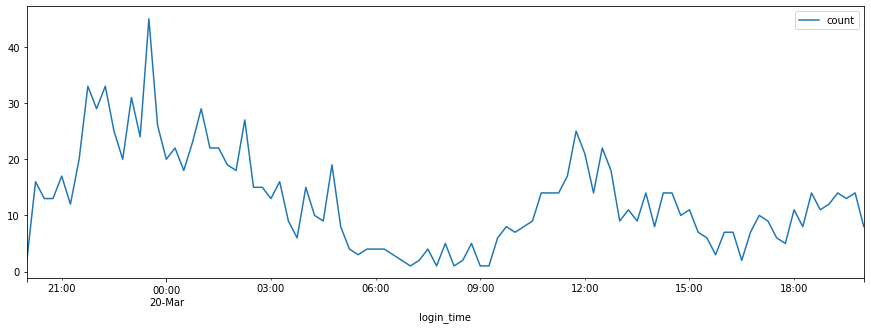

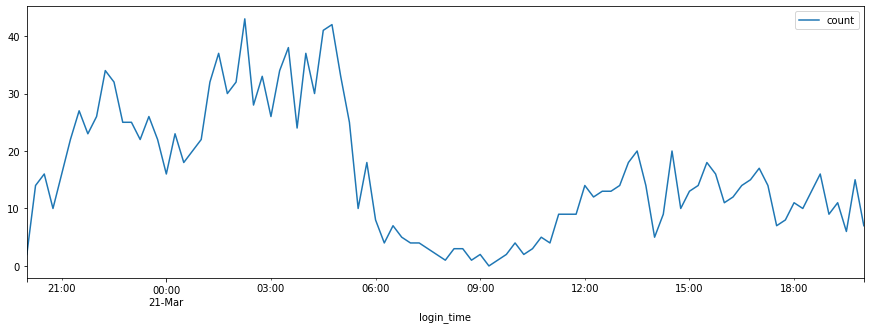

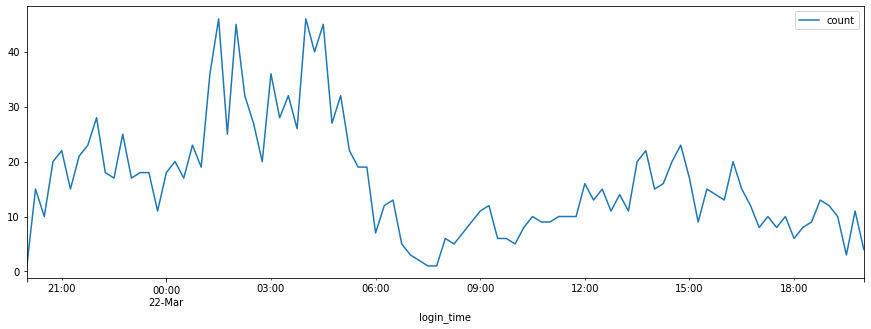

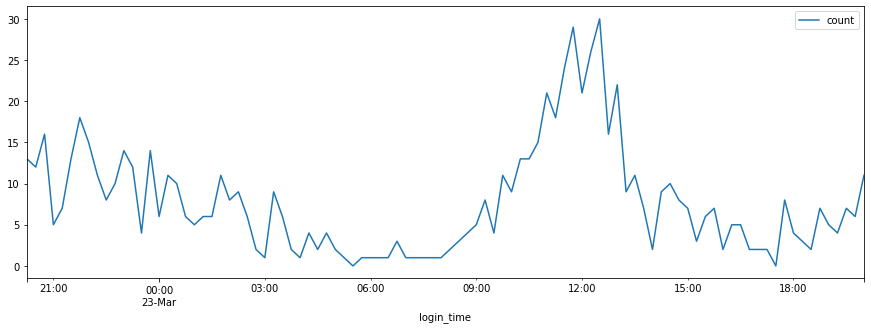

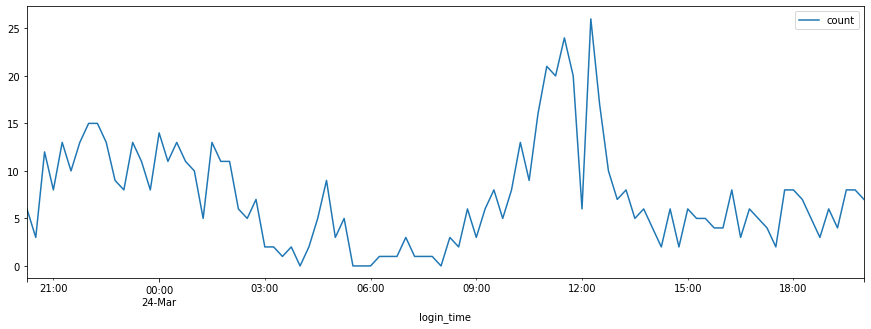

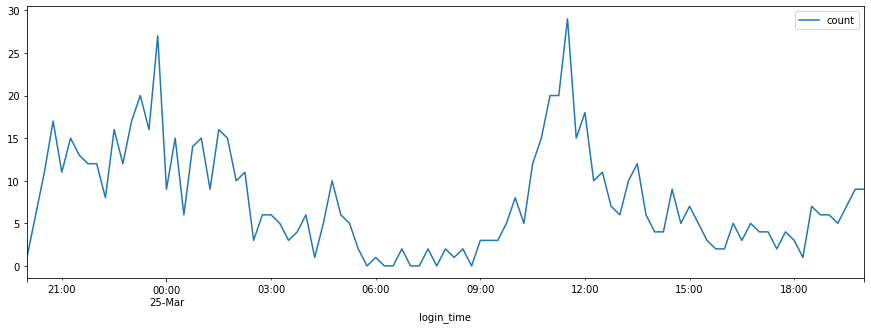

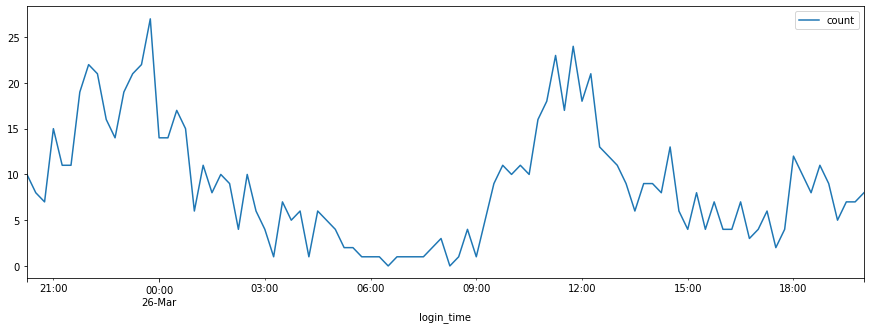

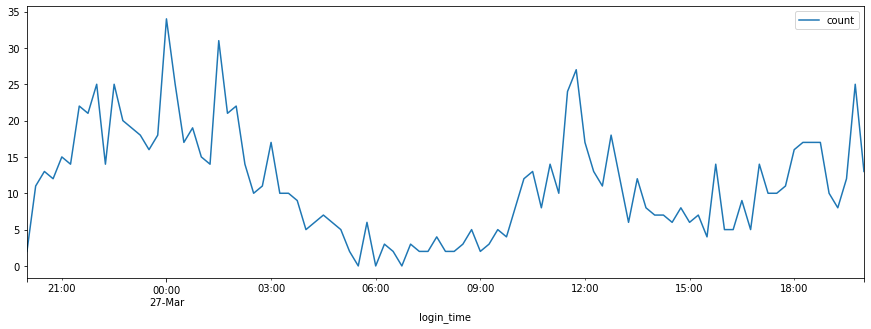

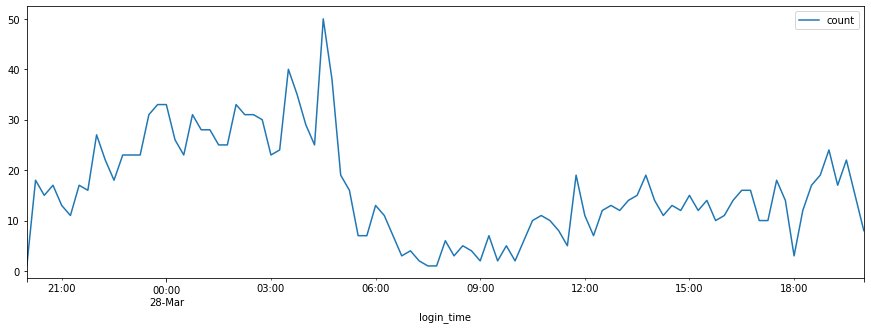

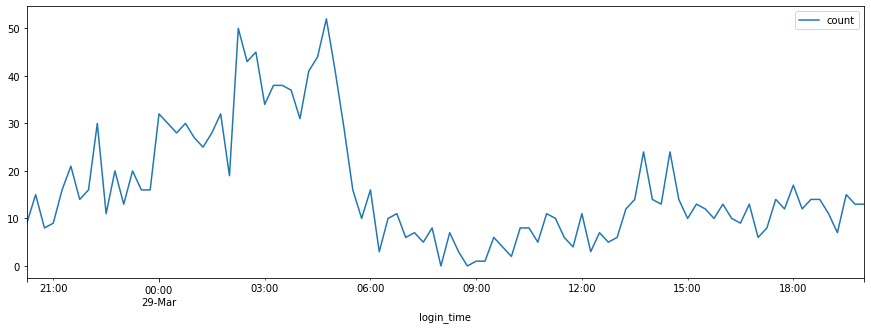

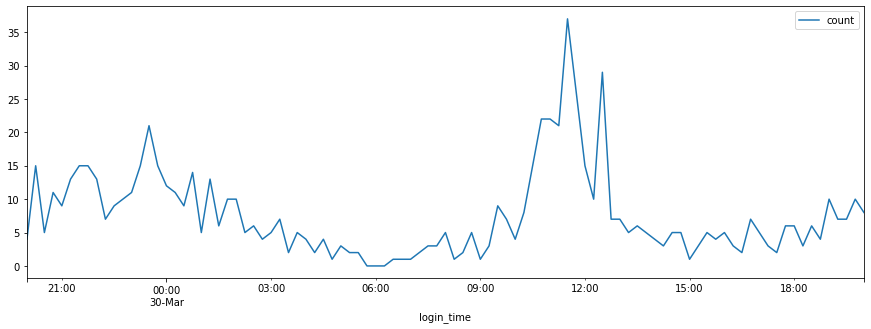

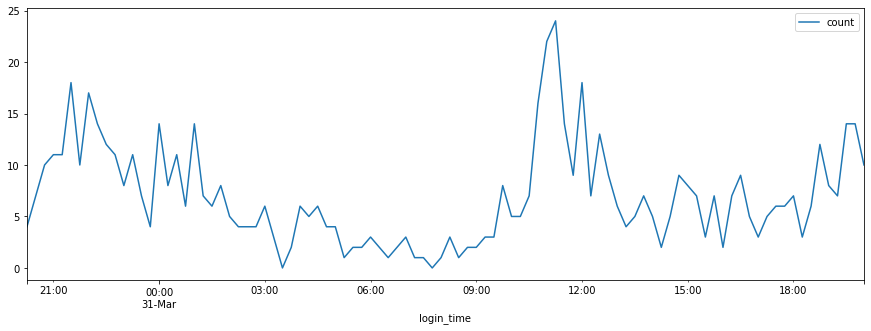

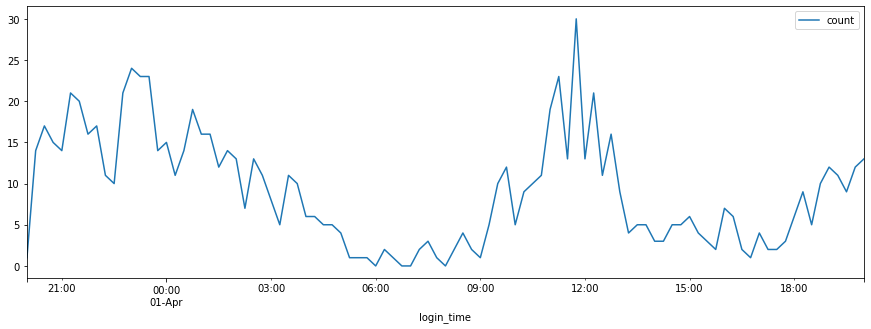

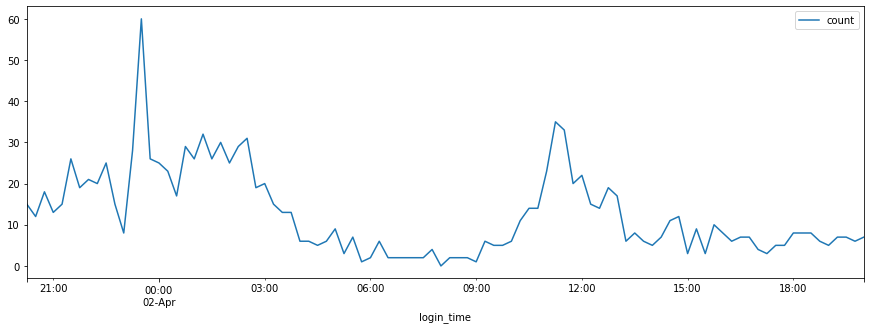

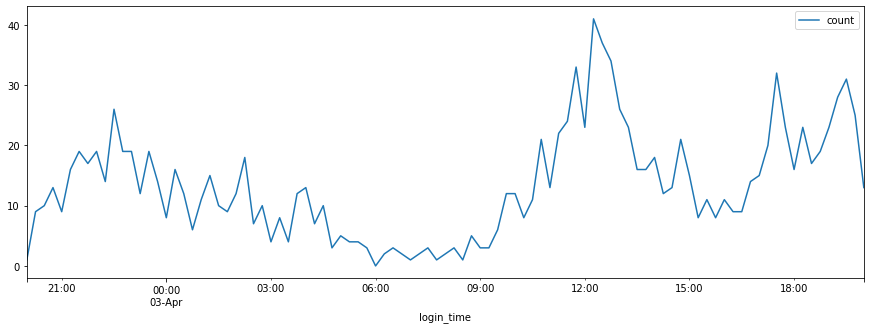

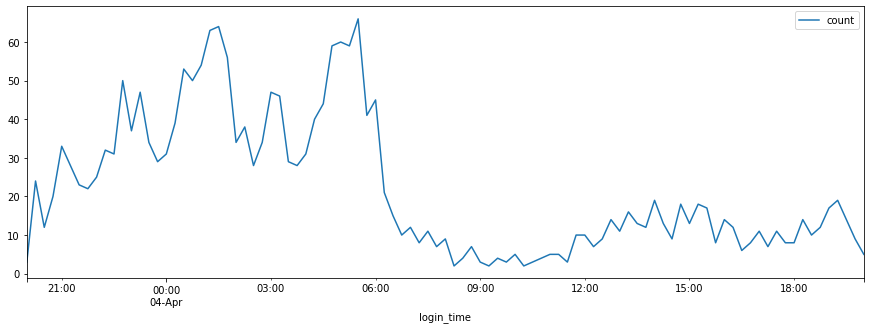

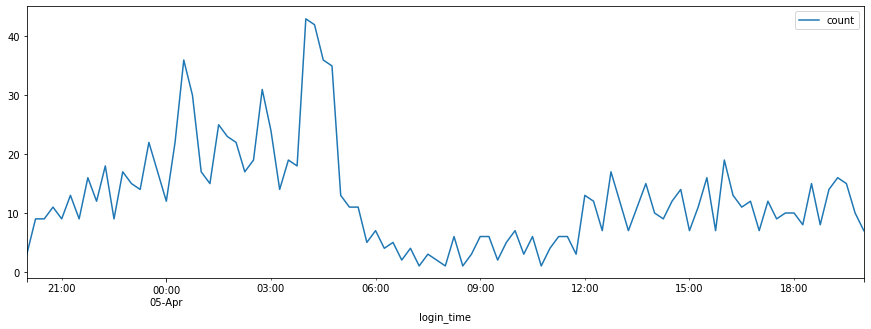

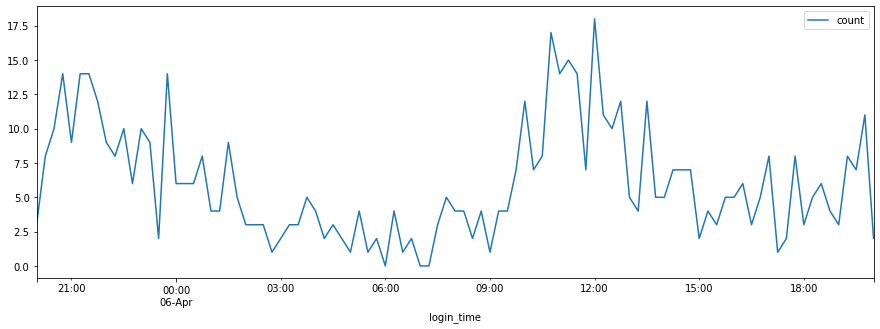

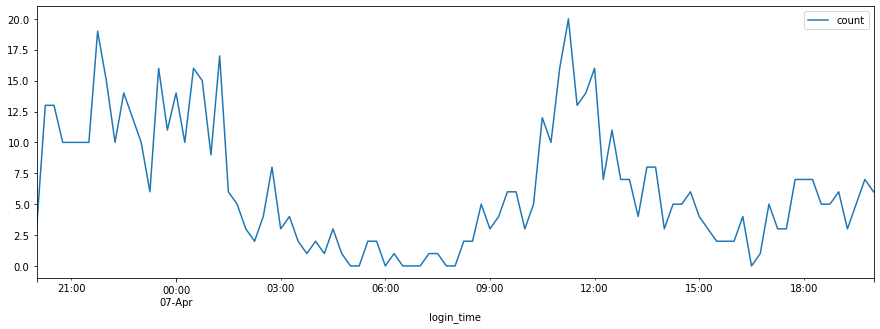

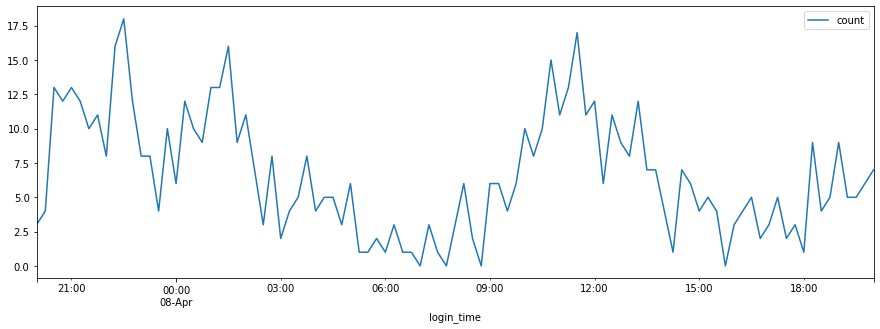

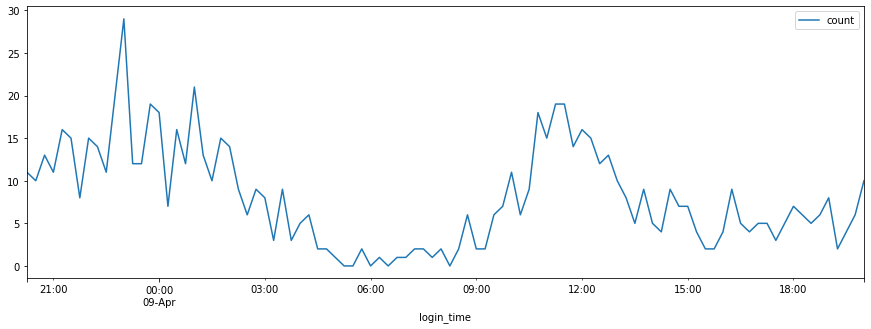

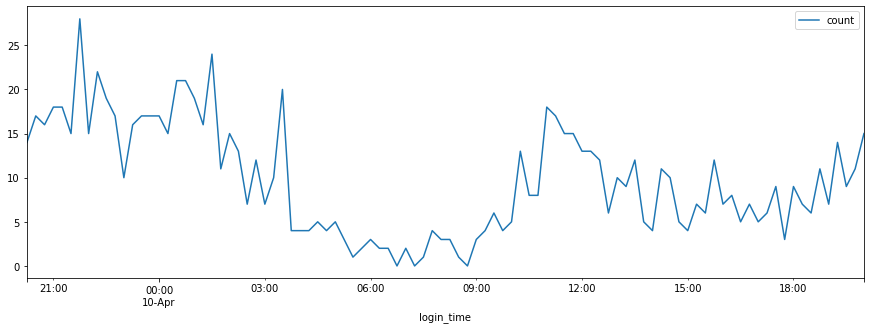

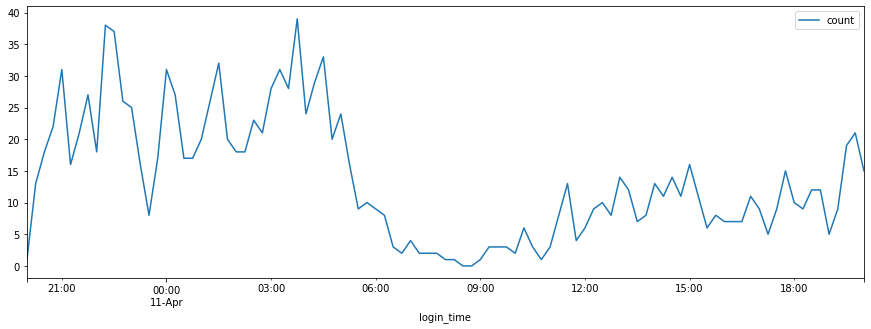

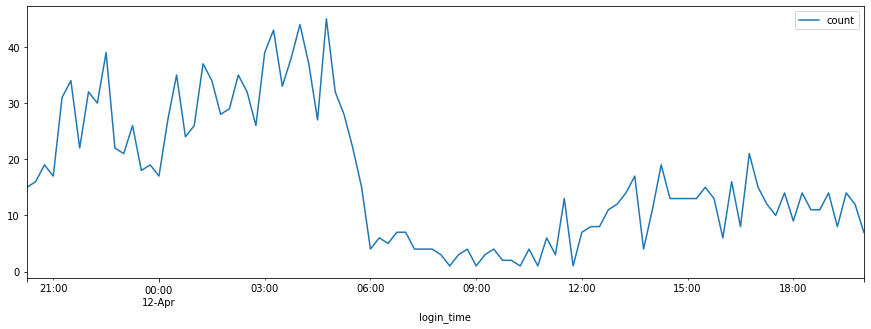

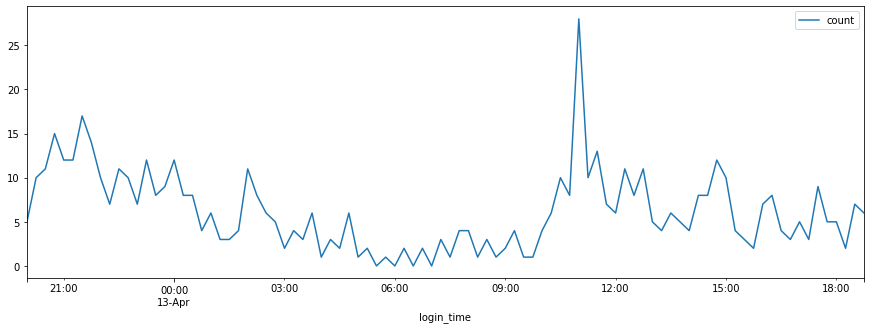

In [14]:
start = logins.index[0]

# Create plots of daily volume activity for fifteen minute intervals every day
while start < logins.index[-1]:
    end = start + tdelta24
    tempDF = logins[(logins.index >= start) & (logins.index < end)]
    start = end
    resample = tempDF.resample('15T').sum()
    resample.plot(figsize=(15,5))
    plt.show()

    

Each graph above shows the volume every 15 minutes for each 24 hour period in the data. Looking at each day individually, the same two peak pattern is observed as seen in the first 24 hours above. There are clear spikes in activity during the lunch and nighttime hours. This trend can be seen in almost every day observed. There are some days lacking the expected spike in either the lunch or night timeframes. These could be caused by a number of factors such as weekends, holidays, etc.

### Part 1: Conclusion
There are clear cycles of demand seen in 15 minute aggregates over 24 hour periods. Overall demand rises until April where usage drops. There also appear to be spikes in login numbers over the course of a week, indicating a weekly cycle. This can most likely be explained by more users logging in and utilizing services on weekends. 

## Part 2: Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.



### 1)

One metric would be the amount of money reimbursed. This could be analyzed in different ways, to include per driver, per day, etc. Knowing the amount of money reimbursed gives an indirect indication of the number of times a driver crossed the toll bridge. A toll bridge crossing indicates availability in both cities, hence amount reimbursed can be a measure of success. 

### 2)

Success here is availability in both cities, which can be indirectly measured by the amount of money reimbursed per driver. If large amounts of drivers are being reimbursed with reasonable amounts each day, then it can be said that these drivers are making themselves available in both cities. 

#### Experiment
One experiment would be to propose a daily stipend of perhaps \\$20 per driver per day. This stipend could be used on anything from gas, to snacks while driving, to paying for tolls. Drivers who present toll receipts, indicating availability in both cities, will be reimbursed for the amount spent on the tolls. In this way, the toll is effectively eliminated for drivers who wish to take advantage of the alternating busy cycles between the cities. At the end of the test period the $20 stipend would disappear from all drivers and a decision would be made whether or not to implement the program based on the test results.

#### Statistical Comparisons
Many comparisons can be made to evaluate the effectiveness of the stipend. Such metrics include the percentage of reimbursements as a whole, reimbursements per driver, daily and nightly reimbursement trends, and many more. A large percentage of reimbursements would indicate that if the toll was not an issue, drivers would pay it and be available in both cities.

To make statistical comparisons, the 95% confidence interval for reimbursements per day could be calculated, and the observed reimbursements compared to the current number of tolls paid per driver per day. The null hypothesis would be that drivers will not pay the toll even if they are given a stipend eliminating the toll. The alternative hypothesis would state that drivers will pay the toll if given the money, indicating the desire to be available in both cities.

#### Insights & Recommendations
Results can be interpereted using the t-score and corresponding p-value. If the p-value is below a confidence threshold of our choosing (perhaps .975 for greater confidence), then we can reject the null hypothesis. This equates to the experiment being a success, showing that multi-city availability would increase if tolls were reimbursed. This information would be used to guide the decision making process of whether or not to implement the program. 

#### Caviats
Certain drivers may beforced to pay a toll because of the city they live in, their main city availability preference, and the natural opposing cycles of the cities. This would skew the results, making it look like there is more availability in each city, when, in fact, a driver was only available in one city but had to pay a toll to get there and back home.  A very large population of such drivers could render the results completely inaccurate. Knowledge of home location and main city of availability would help to eliminate this bias.

## Part 3: Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).


### 1
First, the set is visualized in a dataframe, then summary statistics are explored to get a feel for the data. Next, certain values are obtained like the total number of riders and the total number retained. Visualizations help to recognize trends which can be exploited by feature engineering are explored.

In [10]:
# Read the data into a dataframe
riders = pd.read_json('ultimate_data_challenge.json')
riders.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [11]:
# Set the last date as the index and transform to datetime objects
riders['last_trip_date'] = pd.to_datetime(riders['last_trip_date'])
riders['signup_date'] = pd.to_datetime(riders['signup_date'])
riders.set_index('last_trip_date', drop=True, inplace=True)
riders['phone'].fillna(value = 0, inplace=True)

#Sort the trip dates from most recent to least
riders = riders.sort_index(ascending = False)

# Map city names into numerical values
object_dict = {'King\'s Landing': 1, 'Winterfell': 2, 'Astapor': 3, 'iPhone': 4, 'Android': 5}
object_dict2 = {True: 1, False: 0}

riders_mapped = riders.replace({'city': object_dict, 'phone': object_dict, 'ultimate_black_user': object_dict2})

riders_mapped.head()

city  trips_in_first_30_days signup_date  \
last_trip_date                                             
2014-07-01         2                       4  2014-01-25   
2014-07-01         1                       1  2014-01-15   
2014-07-01         3                       1  2014-01-24   
2014-07-01         1                       2  2014-01-07   
2014-07-01         1                       5  2014-01-16   

                avg_rating_of_driver  avg_surge  phone  surge_pct  \
last_trip_date                                                      
2014-07-01                       5.0       1.00      5        0.0   
2014-07-01                       5.0       1.01      4        0.8   
2014-07-01                       4.3       1.11      4       14.3   
2014-07-01                       4.9       1.02      4        1.6   
2014-07-01                       5.0       1.00      4        0.0   

                ultimate_black_user  weekday_pct  avg_dist  \
last_trip_date                                               
2014-07-01                        1         25.0     11.94   
2014-07-01                        1         89.3      5.49   
2014-07-01                        0         71.4      8.62   
2014-07-01                        1         95.2      7.51   
2014-07-01                        0         75.0     16.32   

                avg_rating_by_driver  
last_trip_date                        
2014-07-01                       5.0  
2014-07-01                       4.7  
2014-07-01                       4.9  
2014-07-01                       4.8  
2014-07-01                       5.0

In [12]:
# Get info on datatypes and null values
riders_mapped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50000 entries, 2014-07-01 to 2014-01-01
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  int64         
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   phone                   50000 non-null  int64         
 6   surge_pct               50000 non-null  float64       
 7   ultimate_black_user     50000 non-null  int64         
 8   weekday_pct             50000 non-null  float64       
 9   avg_dist                50000 non-null  float64       
 10  avg_rating_by_driver    49799 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 4.6 MB


In [13]:
# View summary statistics
riders_mapped.describe()

city  trips_in_first_30_days  avg_rating_of_driver  \
count  50000.000000            50000.000000          41878.000000   
mean       2.128080                2.278200              4.601559   
std        0.718948                3.792684              0.617338   
min        1.000000                0.000000              1.000000   
25%        2.000000                0.000000              4.300000   
50%        2.000000                1.000000              4.900000   
75%        3.000000                3.000000              5.000000   
max        3.000000              125.000000              5.000000   

          avg_surge         phone     surge_pct  ultimate_black_user  \
count  50000.000000  50000.000000  50000.000000          50000.00000   
mean       1.074764      4.268760      8.849536              0.37708   
std        0.222336      0.595764     19.958811              0.48466   
min        1.000000      0.000000      0.000000              0.00000   
25%        1.000000      4.000000      0.000000              0.00000   
50%        1.000000      4.000000      0.000000              0.00000   
75%        1.050000      5.000000      8.600000              1.00000   
max        8.000000      5.000000    100.000000              1.00000   

        weekday_pct      avg_dist  avg_rating_by_driver  
count  50000.000000  50000.000000          49799.000000  
mean      60.926084      5.796827              4.778158  
std       37.081503      5.707357              0.446652  
min        0.000000      0.000000              1.000000  
25%       33.300000      2.420000              4.700000  
50%       66.700000      3.880000              5.000000  
75%      100.000000      6.940000              5.000000  
max      100.000000    160.960000              5.000000

In [14]:
# Fill in missing numeric values with the column averages, and character values with 'unknown'
avg_rate_of_driver = riders['avg_rating_of_driver'].mean()
avg_rate_by_driver = riders['avg_rating_by_driver'].mean()

riders_mapped['avg_rating_of_driver'].fillna(value = avg_rate_of_driver, inplace=True)
riders_mapped['avg_rating_by_driver'].fillna(value = avg_rate_by_driver, inplace=True)

riders_mapped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50000 entries, 2014-07-01 to 2014-01-01
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  int64         
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   phone                   50000 non-null  int64         
 6   surge_pct               50000 non-null  float64       
 7   ultimate_black_user     50000 non-null  int64         
 8   weekday_pct             50000 non-null  float64       
 9   avg_dist                50000 non-null  float64       
 10  avg_rating_by_driver    50000 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 4.6 MB


With all of the data now filled, it is ready for exploratory data analysis.

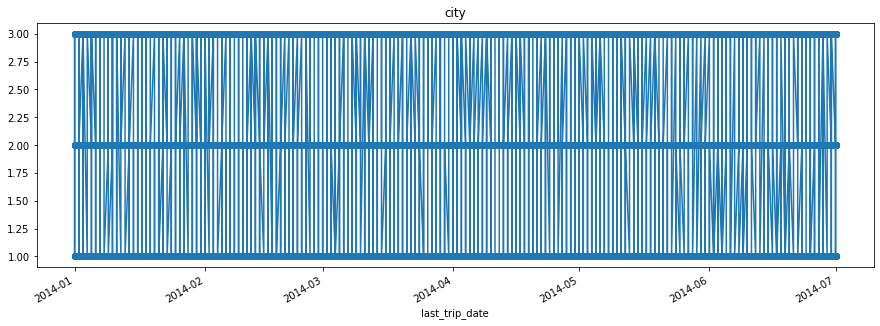

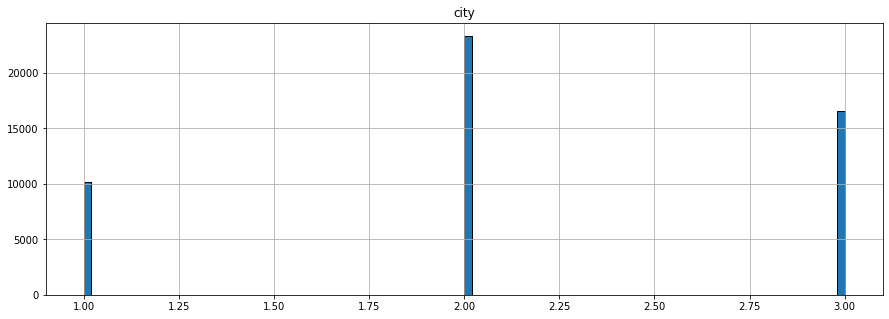

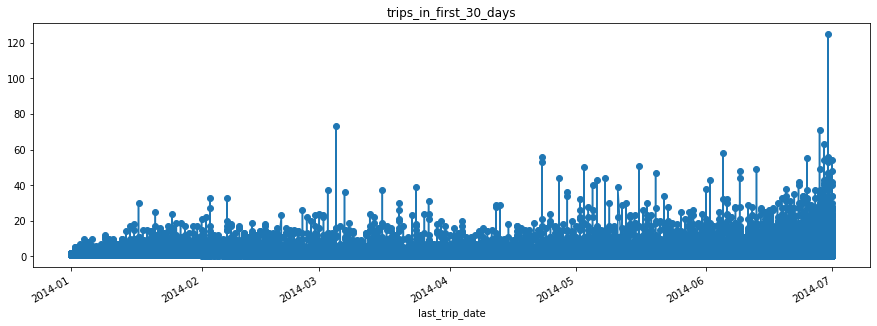

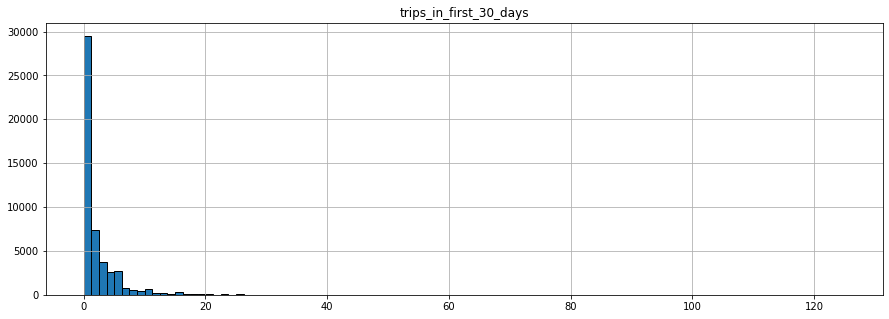

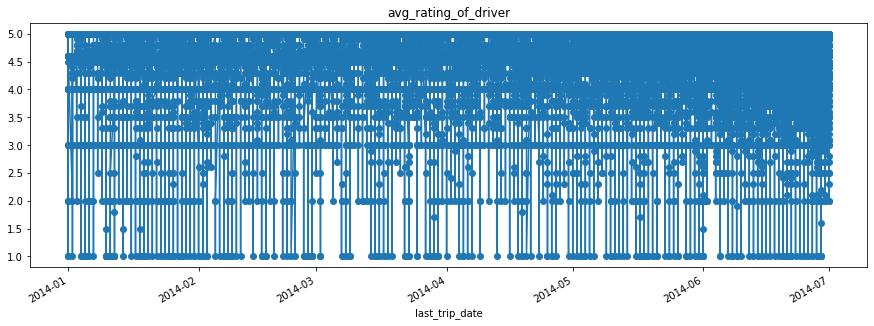

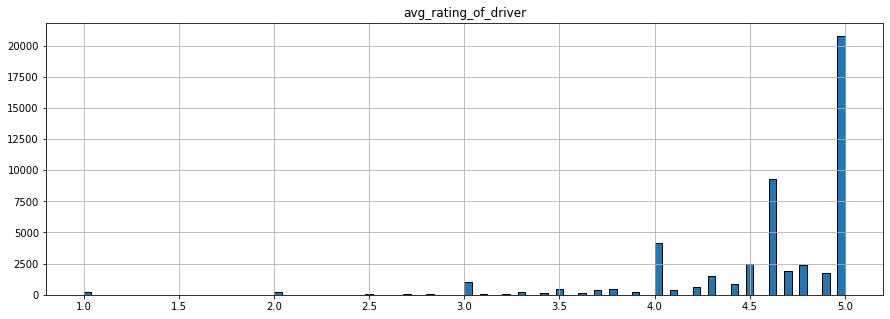

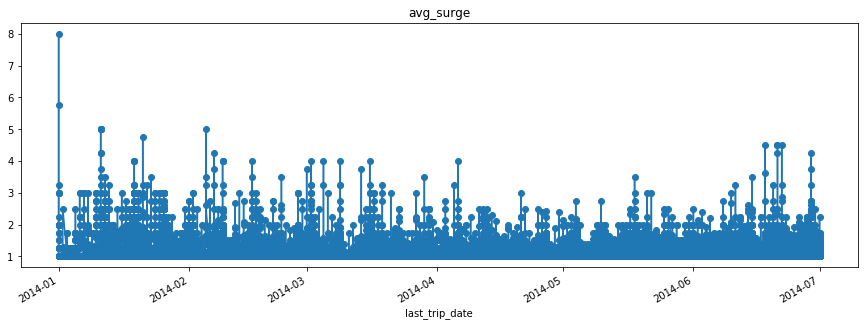

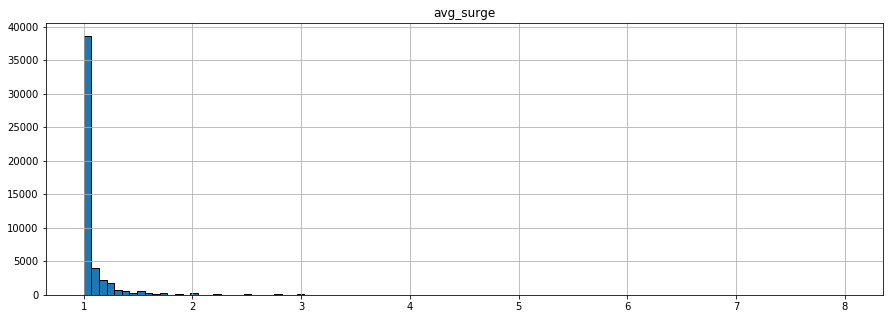

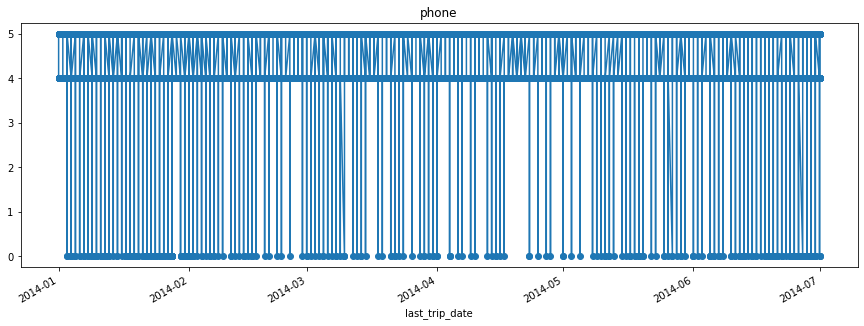

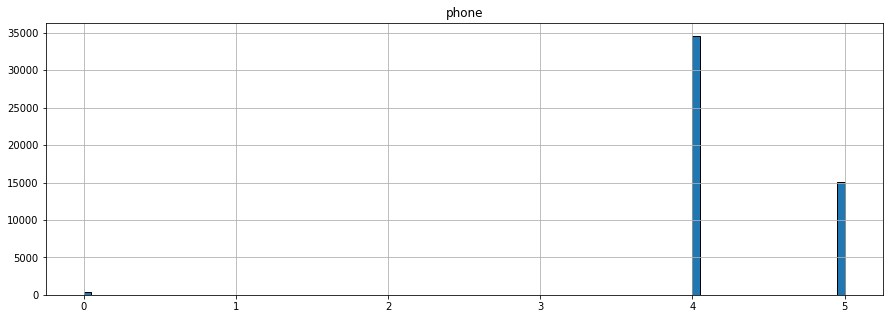

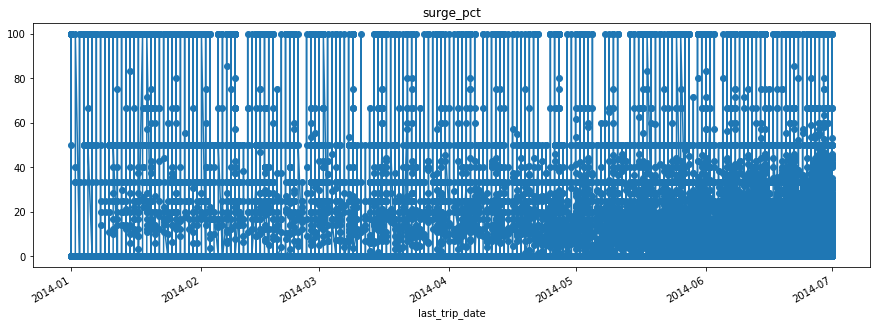

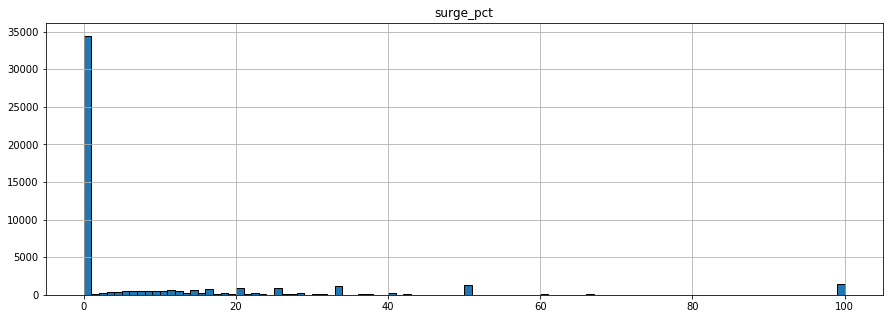

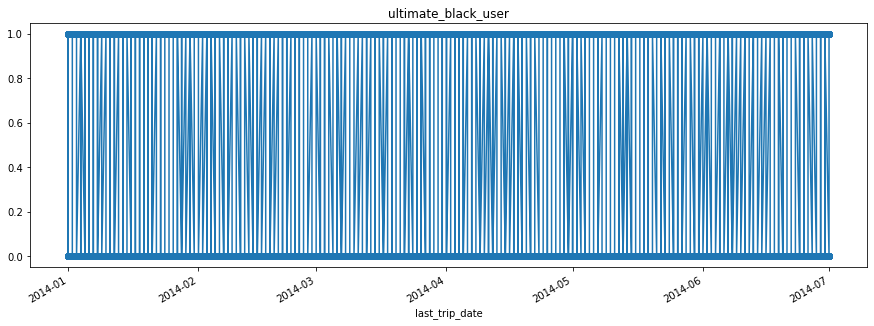

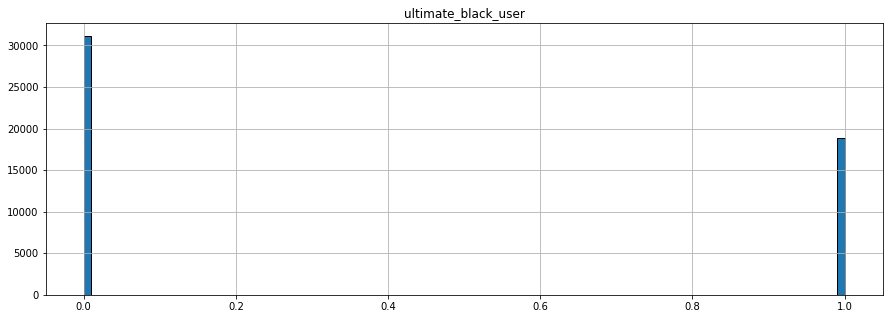

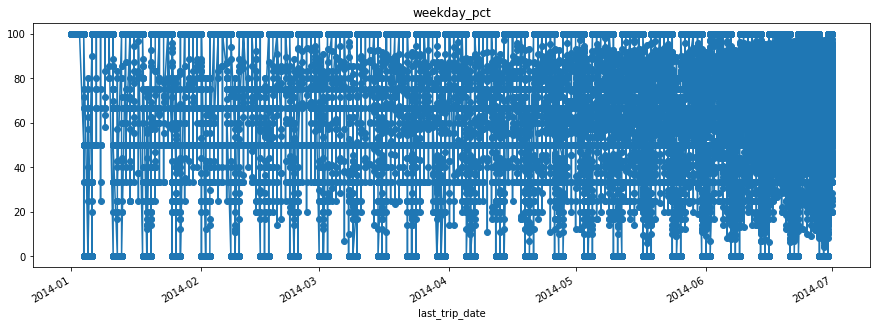

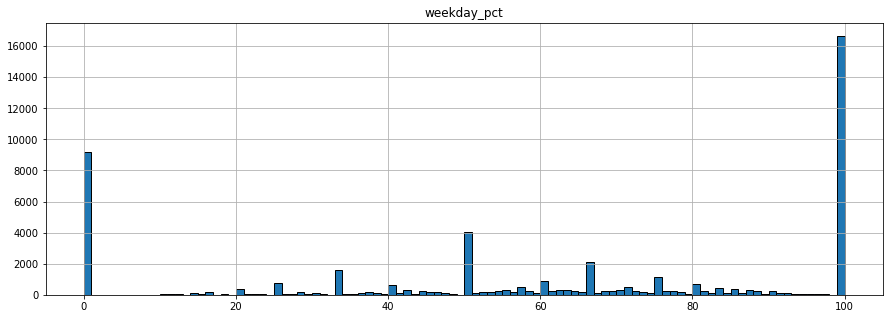

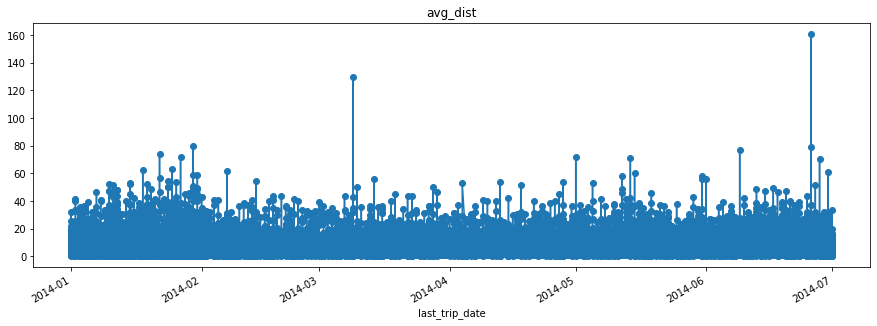

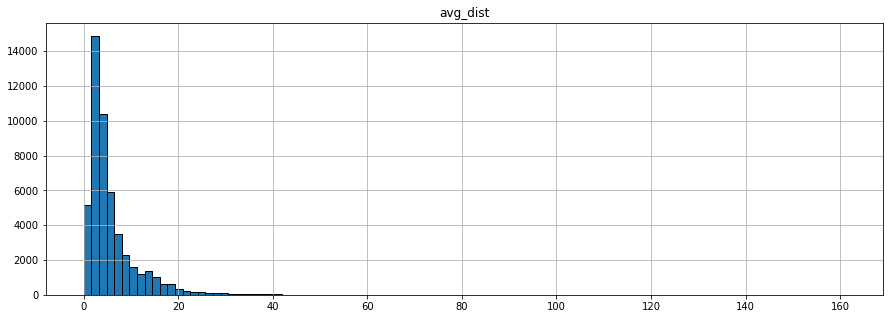

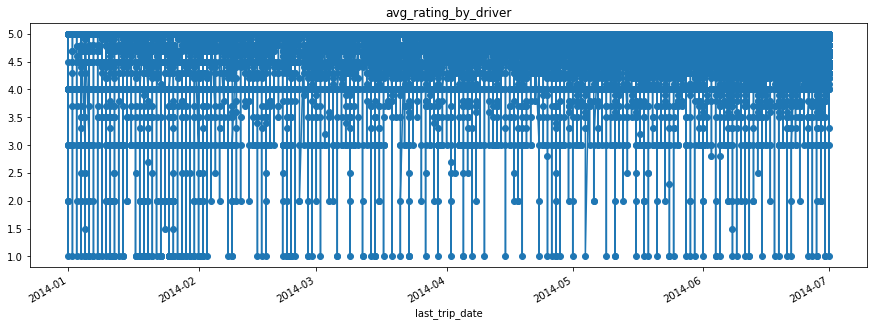

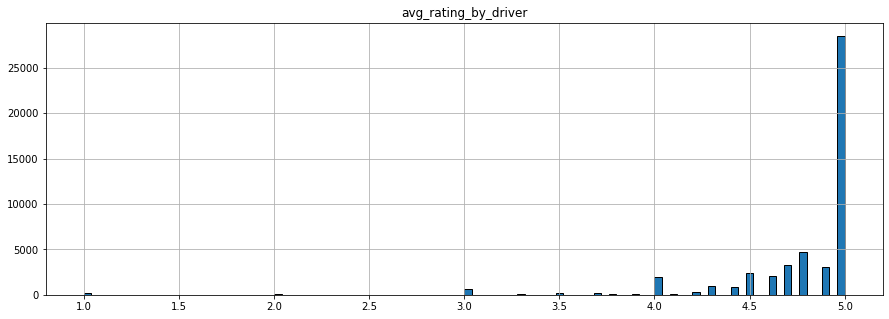

In [15]:
for col in riders_mapped.drop('signup_date', axis=1).columns:
    riders_mapped[col].plot(figsize=(15,5), style=None, marker='o', include_bool=True)
    plt.title(col)
    plt.show()
    riders_mapped[col].hist(figsize=(15,5), bins=100, edgecolor='k')
    plt.title(col)
    plt.show()

In [16]:
# Extract pertinent values from the dataframe
num_riders = riders.shape[0]
days30 = dt.timedelta(days=30)
retention_date = max(riders.index - days30)
num_retained = riders[riders.index >= retention_date].shape[0]
percent_retained = round(num_retained / num_riders * 100,2)
print('\nThere are {} retained riders.'.format(num_retained))
print('\nThe retention rate is {}%.'.format(percent_retained))


There are 18804 retained riders.

The retention rate is 37.61%.


In [17]:
riders_mapped.groupby('ultimate_black_user').sum()

city  trips_in_first_30_days  avg_rating_of_driver  \
ultimate_black_user                                                        
0                    66425                   60644         143346.399902   
1                    39979                   53266          86731.564662   

                     avg_surge   phone  surge_pct  weekday_pct   avg_dist  \
ultimate_black_user                                                         
0                     33899.10  134168   327311.2    1865256.8  176079.35   
1                     19839.09   79270   115165.6    1181047.4  113761.98   

                     avg_rating_by_driver  
ultimate_black_user                        
0                           148719.752419  
1                            90188.157379

In [23]:
riders_sums = riders.groupby('city').sum()
riders_sums

trips_in_first_30_days  avg_rating_of_driver  avg_surge  \
city                                                                      
Astapor                          32219               63193.7   17964.55   
King's Landing                   24957               41642.8   10846.26   
Winterfell                       56734               87867.6   24927.38   

                surge_pct  ultimate_black_user  weekday_pct   avg_dist  \
city                                                                     
Astapor          167659.8               6477.0     998158.4   89745.56   
King's Landing   100965.5               4206.0     640543.1   60542.92   
Winterfell       173851.5               8171.0    1407602.7  139552.85   

                avg_rating_by_driver  
city                                  
Astapor                      79065.9  
King's Landing               48968.4  
Winterfell                  109913.2

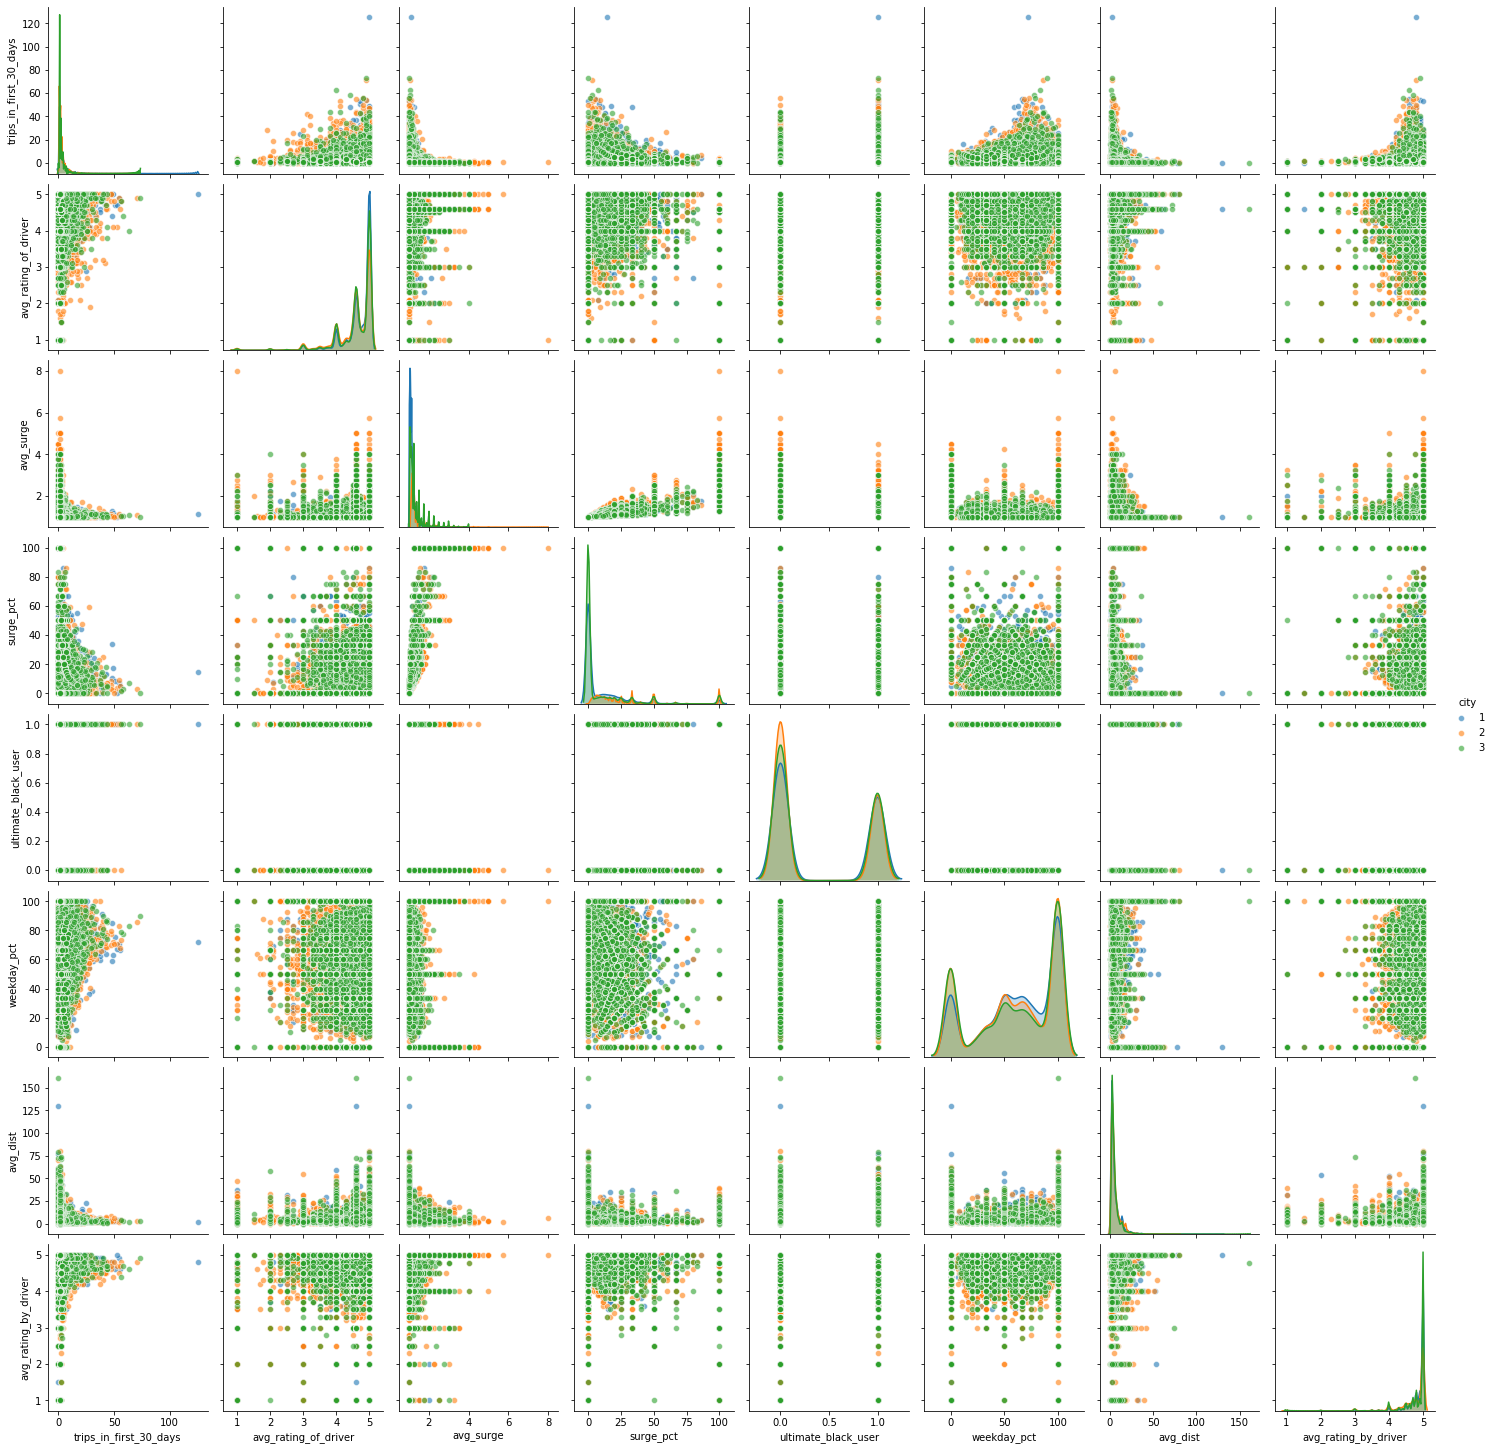

In [24]:
# Create a pairplot to see relationships between numerical columns
_=sns.pairplot(riders_mapped.drop('phone', axis=1), hue='city', plot_kws={'alpha':.6})

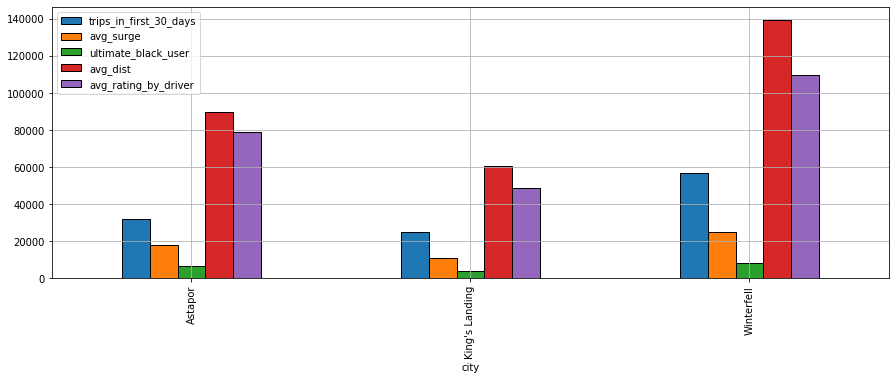

In [24]:
_=riders_sums.drop(['avg_rating_of_driver','surge_pct','weekday_pct'], axis=1).plot(kind='bar', figsize=(15,5), 
                                                                                    grid=True, edgecolor='k')

#### Conclusion
From the total $50,000$ riders that intitially signed up, only $18,804$ were retained. This is a retention rate of $37.6\%$.

### 2

#### Logistic Regression Model

In [19]:
# Add a boolean column called 'retained' for classification
riders_mapped['retained'] = riders.index >= retention_date
riders_mapped.replace({'retained': object_dict2}, inplace=True)

In [26]:
riders_mapped[['trips_in_first_30_days','ultimate_black_user','avg_dist','retained']].groupby('retained').sum()

trips_in_first_30_days  ultimate_black_user   avg_dist
retained                                                        
0                          51738                 9357  193662.85
1                          62172                 9497   96178.48

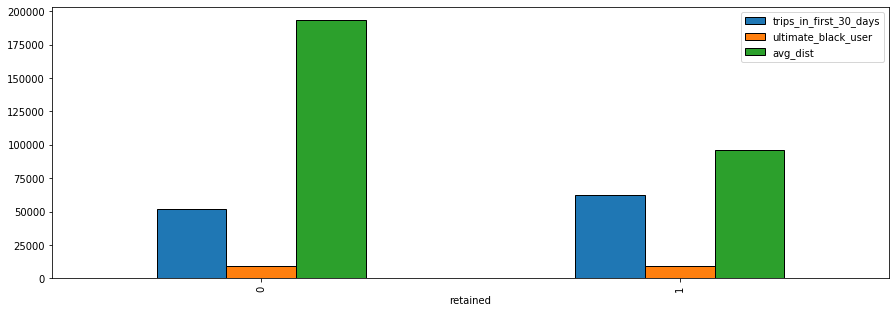

In [27]:
_=riders_mapped[['trips_in_first_30_days','ultimate_black_user','avg_dist','retained']].groupby('retained').sum().plot(
    kind='bar', figsize=(15,5), edgecolor='k')

In [28]:
riders_mapped.drop('weekday_pct', axis=1).groupby('retained').mean()

city  trips_in_first_30_days  avg_rating_of_driver  avg_surge  \
retained                                                                      
0         2.273721                1.658482              4.606309   1.075339   
1         1.886460                3.306318              4.593679   1.073809   

             phone  surge_pct  ultimate_black_user  avg_dist  \
retained                                                       
0         4.346968   8.666739             0.299942  6.207939   
1         4.139013   9.152797             0.505052  5.114788   

          avg_rating_by_driver  
retained                        
0                     4.787415  
1                     4.762801

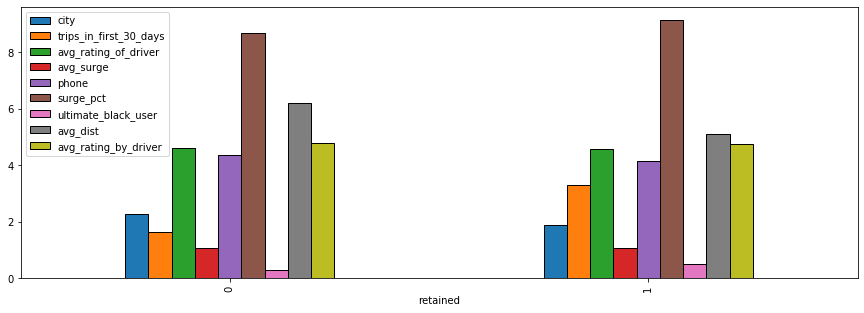

In [29]:
_=riders_mapped.drop('weekday_pct', axis=1).groupby('retained').mean().plot(
    kind='bar', figsize=(15,5), edgecolor='k')

In [32]:
# First we will try a logistic regression model; begin by splitting the data into training and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(riders_mapped.drop(['signup_date', 'retained'], axis=1), riders_mapped.retained, test_size=.2)

# Create, train, and score the logistic regression classifier
LR_classifier = LogisticRegression(max_iter=1000, verbose=2)
LR_classifier.fit(Xtrain, ytrain)
predictions = LR_classifier.predict(Xtest)

print('\nA simple logistic regression model scores only {}%.'.format(accuracy_score(predictions, ytest)*100))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



A simple logistic regression model scores only 71.78999999999999%.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


#### Neural Network Model

In [20]:
# Now we will train a neural network to predict retainership; begin by splitting the data into training and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(riders_mapped.drop(['signup_date', 'retained'], axis=1), 
                                                riders_mapped.retained, test_size=.2)

# Creat and train a neural network for classification
neural_net = Sequential()

# Add dense layers
neural_net.add(Dense(55, input_shape=(Xtrain.shape[1],), activation='relu'))
neural_net.add(Dense(55, activation = 'relu'))
neural_net.add(Dense(44, activation = 'relu'))
neural_net.add(Dense(44, activation = 'relu'))
neural_net.add(Dense(22, activation = 'relu'))
neural_net.add(Dense(22, activation = 'relu'))

# Output layer
neural_net.add(Dense(1))

# Compile the model
neural_net.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the neural net
neural_net.fit(Xtrain, ytrain, epochs=100)

# Check the accuracy
accuracy = neural_net.evaluate(Xtest,ytest)
accuracy

Epoch 1/100
40000/40000 [==============================] - 11s 272us/step - loss: 0.2031 - accuracy: 0.6934
Epoch 2/100
40000/40000 [==============================] - 3s 87us/step - loss: 0.1808 - accuracy: 0.7369
Epoch 3/100
40000/40000 [==============================] - 4s 88us/step - loss: 0.1770 - accuracy: 0.7438
Epoch 4/100
40000/40000 [==============================] - 4s 88us/step - loss: 0.1743 - accuracy: 0.7471
Epoch 5/100
40000/40000 [==============================] - 4s 89us/step - loss: 0.1725 - accuracy: 0.7494
Epoch 6/100
40000/40000 [==============================] - 4s 90us/step - loss: 0.1721 - accuracy: 0.7508
Epoch 7/100
40000/40000 [==============================] - 4s 89us/step - loss: 0.1711 - accuracy: 0.7491
Epoch 8/100
40000/40000 [==============================] - 4s 93us/step - loss: 0.1688 - accuracy: 0.7546
Epoch 9/100
40000/40000 [==============================] - 4s 90us/step - loss: 0.1688 - accuracy: 0.7549
Epoch 10/100
40000/40000 [==================

40000/40000 [==============================] - 4s 108us/step - loss: 0.1520 - accuracy: 0.7821
Epoch 77/100
40000/40000 [==============================] - 4s 106us/step - loss: 0.1520 - accuracy: 0.7800
Epoch 78/100
40000/40000 [==============================] - 4s 102us/step - loss: 0.1518 - accuracy: 0.7804
Epoch 79/100
40000/40000 [==============================] - 4s 102us/step - loss: 0.1515 - accuracy: 0.7816
Epoch 80/100
40000/40000 [==============================] - 4s 102us/step - loss: 0.1514 - accuracy: 0.7814
Epoch 81/100
40000/40000 [==============================] - 4s 102us/step - loss: 0.1518 - accuracy: 0.7810
Epoch 82/100
40000/40000 [==============================] - 4s 101us/step - loss: 0.1519 - accuracy: 0.7808
Epoch 83/100
40000/40000 [==============================] - 4s 102us/step - loss: 0.1511 - accuracy: 0.7814
Epoch 84/100
40000/40000 [==============================] - 4s 102us/step - loss: 0.1516 - accuracy: 0.7811
Epoch 85/100
40000/40000 [===============

[0.1630190152525902, 0.7669000029563904]

In [21]:
neural_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 55)                605       
_________________________________________________________________
dense_2 (Dense)              (None, 55)                3080      
_________________________________________________________________
dense_3 (Dense)              (None, 44)                2464      
_________________________________________________________________
dense_4 (Dense)              (None, 44)                1980      
_________________________________________________________________
dense_5 (Dense)              (None, 22)                990       
_________________________________________________________________
dense_6 (Dense)              (None, 22)                506       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

#### Feature Engineering

Next, a few randomly chosen features are used create new columns of data. The new data is derived from the original data, but mathematical manipulation may help to separate the populations into more easily discernable groups.

In [ ]:
#Introduce some non-linear combinations into the dataframe:
riders_mapped['exp_1'] = (riders_mapped['trips_in_first_30_days'] * riders_mapped.phone**3)
riders_mapped['exp_2'] = riders_mapped.phone**4 / (riders_mapped.city + riders_mapped.ultimate_black_user)**2
riders_mapped['exp_3'] = riders_mapped.avg_dist**2 / (riders_mapped.avg_rating_by_driver**5 + riders_mapped.ultimate_black_user)
riders_mapped['exp_4'] = abs(riders_mapped['trips_in_first_30_days']**2 + riders_mapped.avg_dist**2) / (riders_mapped.retained + 1)**2



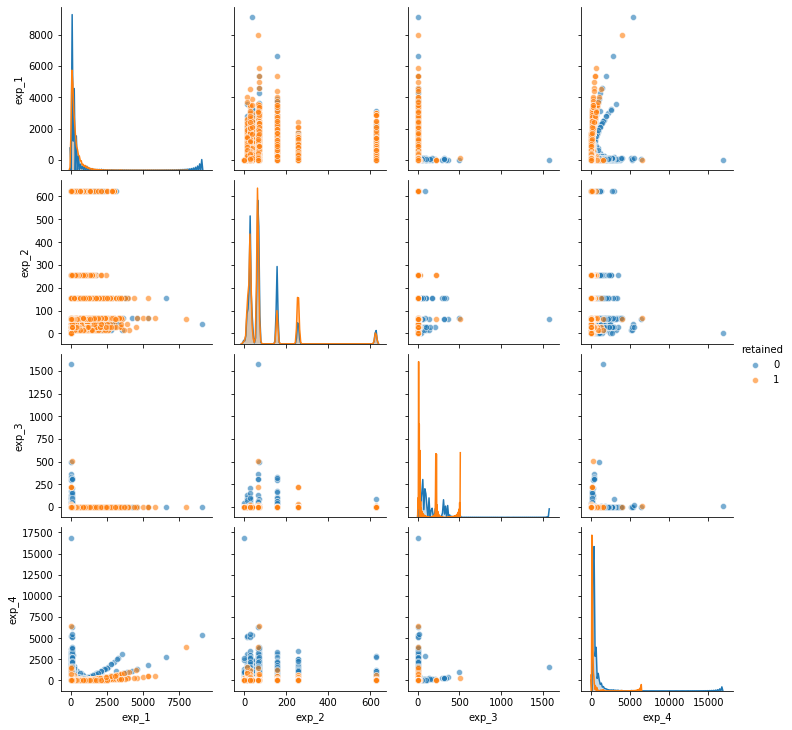

In [54]:
_=sns.pairplot(riders_mapped[['retained', 'exp_1', 'exp_2', 'exp_3', 'exp_4']], hue='retained', plot_kws={'alpha':.6})

In [58]:
Xtrain, Xtest, ytrain, ytest = train_test_split(riders_mapped.drop(['signup_date', 'retained'], axis=1), 
                                                riders_mapped.retained, test_size=.2)

# Creat and train a neural network for classification
neural_net = Sequential()

# Add dense layers
neural_net.add(Dense(55, input_shape=(Xtrain.shape[1],), activation='relu'))
neural_net.add(Dense(55, activation = 'relu'))
neural_net.add(Dense(44, activation = 'relu'))
neural_net.add(Dense(44, activation = 'relu'))
neural_net.add(Dense(22, activation = 'relu'))
neural_net.add(Dense(22, activation = 'relu'))

# Output layer
neural_net.add(Dense(1))

# Compile the model
neural_net.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Fit the neural net with the new features added
neural_net.fit(Xtrain, ytrain, epochs=100)

Epoch 1/100
40000/40000 [==============================] - 9s 216us/step - loss: 0.6185 - accuracy: 0.6543
Epoch 2/100
40000/40000 [==============================] - 4s 102us/step - loss: 0.1153 - accuracy: 0.8760
Epoch 3/100
40000/40000 [==============================] - 4s 95us/step - loss: 0.0379 - accuracy: 0.9686
Epoch 4/100
40000/40000 [==============================] - 4s 95us/step - loss: 0.0274 - accuracy: 0.9785
Epoch 5/100
40000/40000 [==============================] - 4s 96us/step - loss: 0.0180 - accuracy: 0.9841
Epoch 6/100
40000/40000 [==============================] - 4s 97us/step - loss: 0.0255 - accuracy: 0.9821
Epoch 7/100
40000/40000 [==============================] - 4s 97us/step - loss: 0.0123 - accuracy: 0.9885
Epoch 8/100
40000/40000 [==============================] - 4s 100us/step - loss: 0.0080 - accuracy: 0.9911
Epoch 9/100
40000/40000 [==============================] - 4s 99us/step - loss: 0.0093 - accuracy: 0.9906
Epoch 10/100
40000/40000 [=================

40000/40000 [==============================] - 4s 107us/step - loss: 0.0014 - accuracy: 0.9982
Epoch 77/100
40000/40000 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.99 - 5s 117us/step - loss: 0.0012 - accuracy: 0.9986
Epoch 78/100
40000/40000 [==============================] - 5s 113us/step - loss: 0.0017 - accuracy: 0.9980
Epoch 79/100
40000/40000 [==============================] - 5s 117us/step - loss: 0.0011 - accuracy: 0.9987
Epoch 80/100
40000/40000 [==============================] - 5s 119us/step - loss: 0.0012 - accuracy: 0.9985
Epoch 81/100
40000/40000 [==============================] - 5s 125us/step - loss: 0.0018 - accuracy: 0.9979
Epoch 82/100
40000/40000 [==============================] - 4s 109us/step - loss: 0.0011 - accuracy: 0.9988
Epoch 83/100
40000/40000 [==============================] - 4s 110us/step - loss: 0.0012 - accuracy: 0.9985
Epoch 84/100
40000/40000 [==============================] - 4s 109us/step - loss: 0.0016 - accuracy: 0.9982

[0.0012160676606330072, 0.9984999895095825]

In [66]:
# Check the accuracy
error, accuracy = neural_net.evaluate(Xtest,ytest)
accuracy = round(accuracy * 100, 2)
print('\nThe neural network performs very well with the newly designed features, with an accuracy of {}%'.format(accuracy))

10000/10000 [==============================] - 1s 132us/step

The neural network performs very well with the newly designed features, with an accuracy of 99.85%


Adding designed features completely changed the perceptron's ability to classify the users. These features were chosen semi-randomly, with the idea of manipulating the binary variables through addition or exponentiation. It can be considered fortunate that these experimental features worked rather well. Further analysis could be made to find the significance of each feature and drop those that are not needed; the model could also be optimized further through more detailed exploration of layer depth and number of neurons in each node. By optimizing the model, computational resources will be minimized while the performance is still exceptional.

### 3
#### Insights


Long term rider retention can be increased by adding incentives that lead to more trips in the first 30 days. There is a significant divergence between the retained riders' total average distance and those that churned. Decreasing the total average distance could enhance retainership. Ultimate Black users also tend to keep using the service, so increasing that population could lead to better overall retention as well. 